In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import copy
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 100
epochs_pretrain = 3 #3
epochs_optimal_lr = 3 #5
patience_teacher = 1
patience_student = 5
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
lmda = 3
batch_size = 76
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_student = [5,3,10,0.5,0]
lmda_list_teacher = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

# Start Training Process

In [12]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [13]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [14]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [15]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [16]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [18]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [19]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [20]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [21]:
# Function to train the teacher model


def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
        
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        if lmda != 0:
        # Train the adversary at the start of each epoch
            train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epoch}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|███████████████████████████████████████████| 46/46 [00:18<00:00,  2.42it/s]


*****Epoch 1/100*****
*****Train Loss:  0.018759 Val Loss:  2.608996*****
*****Validation Accuracy: 62.31%*****
*****Total Avg Disparity: 0.1453473463011326*****

Class Team_Sports: Recall Difference = 0.020493956910141997
Class Celebration: Recall Difference = -0.013953488372092981
Class Parade: Recall Difference = 0.04949566033309882
Class Waiter_Or_Waitress: Recall Difference = -0.13120567375886516
Class Individual_Sports: Recall Difference = -0.13577926471693857
Class Surgeons: Recall Difference = 0.11868131868131876
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.18055555555555558
Class Business: Recall Difference = -0.052216538789428835
Class Dresses: Recall Difference = -0.7321428571428572
Class Water Activities: Recall Difference = 0.14622744074798866
Class Picnic: Recall Difference = 0.05555555555555558
Class Rescue: Recall Difference = 0.15138816134101626
Class Cheering: Recall Difference = -0.012479541734860877
Class Performanc

100%|███████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 2/100*****
*****Train Loss:  0.015082 Val Loss:  2.667948*****
*****Validation Accuracy: 62.14%*****
*****Total Avg Disparity: 0.15290102603621425*****

Class Team_Sports: Recall Difference = 0.08435803117884055
Class Celebration: Recall Difference = -0.06744186046511635
Class Parade: Recall Difference = 0.08585503166783948
Class Waiter_Or_Waitress: Recall Difference = -0.12056737588652477
Class Individual_Sports: Recall Difference = -0.1711149537628749
Class Surgeons: Recall Difference = 0.058608058608058566
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.20138888888888873
Class Business: Recall Difference = -0.1457800511508952
Class Dresses: Recall Difference = -0.6845238095238095
Class Water Activities: Recall Difference = 0.07838660578386591
Class Picnic: Recall Difference = 0.14814814814814803
Class Rescue: Recall Difference = 0.08119434258774222
Class Cheering: Recall Difference = -0.018617021276595758
Class Performance_

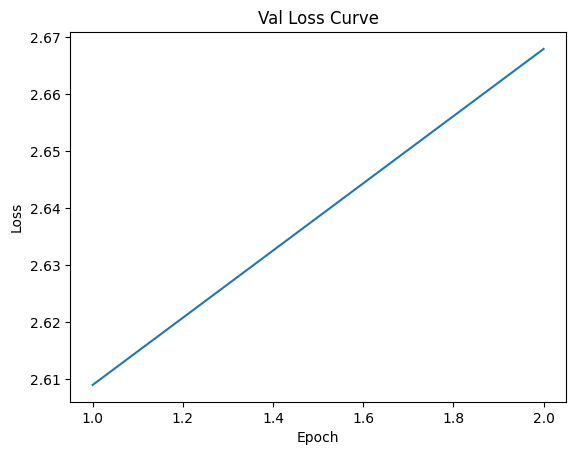

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [22]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    # teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # # Replace the last fully connected layer with a new one
    # teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}2.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}2.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.412242417826372


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.888982487952008


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.601550784181146


100%|█████████████████████████████████████████| 136/136 [01:43<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.43823711442596774


100%|█████████████████████████████████████████| 136/136 [01:43<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.4381299928268966


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.43803733105168624


100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.4177955783465329


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 1/100*****
*****Train Loss: -1.567664 Val Loss: -1.145481*****
*****Validation Accuracy: 62.57%*****
*****Total Avg Disparity: 0.13490264955266396*****

Class Team_Sports: Recall Difference = 0.016231680971565354
Class Celebration: Recall Difference = -0.1418604651162788
Class Parade: Recall Difference = 0.08784893267651894
Class Waiter_Or_Waitress: Recall Difference = -0.10851063829787233
Class Individual_Sports: Recall Difference = -0.15002631381099185
Class Surgeons: Recall Difference = 0.14725274725274723
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.10775862068965503
Class Business: Recall Difference = 0.07736572890025573
Class Dresses: Recall Difference = -0.7023809523809523
Class Water Activities: Recall Difference = 0.10078277886497067
Class Picnic: Recall Difference = 0.05555555555555547
Class Rescue: Recall Difference = 0.03745416448402311
Class Cheering: Recall Difference = -0.07692307692307687
Class Performance_A

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.390542438144193


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 2/100*****
*****Train Loss: -1.680652 Val Loss: -1.103209*****
*****Validation Accuracy: 63.72%*****
*****Total Avg Disparity: 0.14445731715074128*****

Class Team_Sports: Recall Difference = 0.05775675833479321
Class Celebration: Recall Difference = 0.086046511627907
Class Parade: Recall Difference = 0.09160215810462125
Class Waiter_Or_Waitress: Recall Difference = -0.17659574468085082
Class Individual_Sports: Recall Difference = -0.13953838057288925
Class Surgeons: Recall Difference = 0.08424908424908417
Class Spa: Recall Difference = -0.11347517730496459
Class Law_Enforcement: Recall Difference = 0.10799808429118762
Class Business: Recall Difference = 0.11125319693094626
Class Dresses: Recall Difference = -0.6726190476190476
Class Water Activities: Recall Difference = 0.13176777560339215
Class Picnic: Recall Difference = 0.03703703703703698
Class Rescue: Recall Difference = 0.16553169198533263
Class Cheering: Recall Difference = -0.0591243862520458
Class Performance_And_E

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.3904033629771541


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 3/100*****
*****Train Loss: -1.748964 Val Loss: -1.068631*****
*****Validation Accuracy: 64.10%*****
*****Total Avg Disparity: 0.147537863188696*****

Class Team_Sports: Recall Difference = 0.025211654113388327
Class Celebration: Recall Difference = 0.10697674418604652
Class Parade: Recall Difference = 0.059699741965751674
Class Waiter_Or_Waitress: Recall Difference = -0.18723404255319143
Class Individual_Sports: Recall Difference = -0.13916246898729423
Class Surgeons: Recall Difference = 0.04981684981684986
Class Spa: Recall Difference = -0.4751773049645391
Class Law_Enforcement: Recall Difference = 0.08045977011494243
Class Business: Recall Difference = 0.054560954816709306
Class Dresses: Recall Difference = -0.5559523809523808
Class Water Activities: Recall Difference = 0.074037834311807
Class Picnic: Recall Difference = -0.01851851851851849
Class Rescue: Recall Difference = 0.09769512833944477
Class Cheering: Recall Difference = -0.0855155482815057
Class Performance_And_

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.377101899289033


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 4/100*****
*****Train Loss: -1.645667 Val Loss: -0.968917*****
*****Validation Accuracy: 64.13%*****
*****Total Avg Disparity: 0.12427107236088014*****

Class Team_Sports: Recall Difference = 0.023074677409937405
Class Celebration: Recall Difference = 0.04418604651162794
Class Parade: Recall Difference = 0.055360075064508574
Class Waiter_Or_Waitress: Recall Difference = -0.25390070921985797
Class Individual_Sports: Recall Difference = -0.15709345162017885
Class Surgeons: Recall Difference = 0.05860805860805851
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.0663314176245211
Class Business: Recall Difference = -0.017263427109974416
Class Dresses: Recall Difference = -0.6785714285714286
Class Water Activities: Recall Difference = 0.1454664057403784
Class Picnic: Recall Difference = -0.05555555555555558
Class Rescue: Recall Difference = 0.1581980094290204
Class Cheering: Recall Difference = -0.04500818330605577
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.36028642021119595


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 5/100*****
*****Train Loss: -1.650226 Val Loss: -0.927654*****
*****Validation Accuracy: 64.53%*****
*****Total Avg Disparity: 0.1412396646300291*****

Class Team_Sports: Recall Difference = 0.06095638465580666
Class Celebration: Recall Difference = -0.04418604651162783
Class Parade: Recall Difference = 0.07635467980295563
Class Waiter_Or_Waitress: Recall Difference = -0.17234042553191498
Class Individual_Sports: Recall Difference = -0.18554995864972557
Class Surgeons: Recall Difference = -0.05567765567765576
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.11518199233716475
Class Business: Recall Difference = -0.08908780903665814
Class Dresses: Recall Difference = -0.5380952380952382
Class Water Activities: Recall Difference = 0.16351380734942345
Class Picnic: Recall Difference = -0.14814814814814825
Class Rescue: Recall Difference = 0.17757988475641695
Class Cheering: Recall Difference = -0.08040098199672668
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.3549214331981014


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 6/100*****
*****Train Loss: -1.655759 Val Loss: -0.965107*****
*****Validation Accuracy: 65.19%*****
*****Total Avg Disparity: 0.16143401479726605*****

Class Team_Sports: Recall Difference = 0.02863315233257424
Class Celebration: Recall Difference = 0.0023255813953486637
Class Parade: Recall Difference = 0.10180623973727432
Class Waiter_Or_Waitress: Recall Difference = -0.24184397163120552
Class Individual_Sports: Recall Difference = -0.22069769190286448
Class Surgeons: Recall Difference = 0.01025641025641022
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.03232758620689635
Class Business: Recall Difference = -0.07502131287297537
Class Dresses: Recall Difference = -0.773809523809524
Class Water Activities: Recall Difference = 0.09067188519243308
Class Picnic: Recall Difference = -0.07407407407407407
Class Rescue: Recall Difference = 0.11471974855945527
Class Cheering: Recall Difference = -0.0992225859247135
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.35157384734381647


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 7/100*****
*****Train Loss: -1.629360 Val Loss: -0.963110*****
*****Validation Accuracy: 65.11%*****
*****Total Avg Disparity: 0.17029527424290616*****

Class Team_Sports: Recall Difference = 0.064097623635196
Class Celebration: Recall Difference = 0.009302325581395432
Class Parade: Recall Difference = 0.08784893267651883
Class Waiter_Or_Waitress: Recall Difference = -0.28581560283687946
Class Individual_Sports: Recall Difference = -0.11431471317946029
Class Surgeons: Recall Difference = 0.04981684981684986
Class Spa: Recall Difference = -0.2624113475177305
Class Law_Enforcement: Recall Difference = 0.12212643678160917
Class Business: Recall Difference = 0.08930093776641085
Class Dresses: Recall Difference = -0.7916666666666666
Class Water Activities: Recall Difference = 0.106544901065449
Class Picnic: Recall Difference = -0.24074074074074076
Class Rescue: Recall Difference = 0.11733892090099529
Class Cheering: Recall Difference = -0.08756137479541737
Class Performance_And_E

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.3467925007948104


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 8/100*****
*****Train Loss: -1.598993 Val Loss: -0.872435*****
*****Validation Accuracy: 65.34%*****
*****Total Avg Disparity: 0.14516393736319644*****

Class Team_Sports: Recall Difference = 0.06903719273661468
Class Celebration: Recall Difference = -0.020930232558139528
Class Parade: Recall Difference = 0.09863945578231292
Class Waiter_Or_Waitress: Recall Difference = -0.2737588652482269
Class Individual_Sports: Recall Difference = -0.1817532516352155
Class Surgeons: Recall Difference = -0.055677655677655646
Class Spa: Recall Difference = 0.007092198581560183
Class Law_Enforcement: Recall Difference = 0.015086206896551713
Class Business: Recall Difference = 0.09910485933503838
Class Dresses: Recall Difference = -0.7202380952380951
Class Water Activities: Recall Difference = 0.10513155033702981
Class Picnic: Recall Difference = -0.27777777777777785
Class Rescue: Recall Difference = 0.0062860136196961625
Class Cheering: Recall Difference = -0.09615384615384615
Class Performa

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.3353035685551517


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 9/100*****
*****Train Loss: -1.588679 Val Loss: -0.880344*****
*****Validation Accuracy: 66.06%*****
*****Total Avg Disparity: 0.1294213812655788*****

Class Team_Sports: Recall Difference = 0.048554913294797775
Class Celebration: Recall Difference = -0.046511627906976716
Class Parade: Recall Difference = 0.04820548909218858
Class Waiter_Or_Waitress: Recall Difference = -0.13900709219858143
Class Individual_Sports: Recall Difference = -0.15683031351026233
Class Surgeons: Recall Difference = -0.02417582417582409
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.11853448275862077
Class Business: Recall Difference = 0.08397271952259167
Class Dresses: Recall Difference = -0.5738095238095238
Class Water Activities: Recall Difference = 0.0986083931289411
Class Picnic: Recall Difference = -0.14814814814814825
Class Rescue: Recall Difference = 0.09795704557359874
Class Cheering: Recall Difference = -0.10229132569558108
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.3324811168234138


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 10/100*****
*****Train Loss: -1.599321 Val Loss: -0.852203*****
*****Validation Accuracy: 64.50%*****
*****Total Avg Disparity: 0.13251067873654465*****

Class Team_Sports: Recall Difference = 0.035534536112570736
Class Celebration: Recall Difference = -0.04651162790697688
Class Parade: Recall Difference = 0.04949566033309871
Class Waiter_Or_Waitress: Recall Difference = -0.2964539007092196
Class Individual_Sports: Recall Difference = -0.16401022479512828
Class Surgeons: Recall Difference = -0.03589743589743588
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.09075670498084287
Class Business: Recall Difference = 0.01449275362318836
Class Dresses: Recall Difference = -0.625
Class Water Activities: Recall Difference = 0.1454664057403784
Class Picnic: Recall Difference = -0.0370370370370372
Class Rescue: Recall Difference = 0.1870089051859612
Class Cheering: Recall Difference = -0.046031096563011464
Class Performance_And_Entertain

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.33306622318923473


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 11/100*****
*****Train Loss: -1.544881 Val Loss: -0.790835*****
*****Validation Accuracy: 64.62%*****
*****Total Avg Disparity: 0.15563466064951165*****

Class Team_Sports: Recall Difference = 0.028574764990949908
Class Celebration: Recall Difference = -0.05813953488372092
Class Parade: Recall Difference = 0.08972554539056998
Class Waiter_Or_Waitress: Recall Difference = -0.19645390070921975
Class Individual_Sports: Recall Difference = -0.2277272385534922
Class Surgeons: Recall Difference = -0.08131868131868125
Class Spa: Recall Difference = 0.13475177304964536
Class Law_Enforcement: Recall Difference = 0.14607279693486586
Class Business: Recall Difference = -0.009590792838874651
Class Dresses: Recall Difference = -0.75
Class Water Activities: Recall Difference = 0.15557729941291576
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = 0.06416972236773183
Class Cheering: Recall Difference = -0.062193126022913214
Class Performance_And_Entert

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.2748769802205703


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.24it/s]


*****Epoch 12/100*****
*****Train Loss: -1.203248 Val Loss: -0.437998*****
*****Validation Accuracy: 64.96%*****
*****Total Avg Disparity: 0.1451319380487449*****

Class Team_Sports: Recall Difference = 0.04625445203479883
Class Celebration: Recall Difference = -0.0930232558139536
Class Parade: Recall Difference = 0.059699741965751785
Class Waiter_Or_Waitress: Recall Difference = -0.19645390070921975
Class Individual_Sports: Recall Difference = -0.14980076685963473
Class Surgeons: Recall Difference = -0.05274725274725267
Class Spa: Recall Difference = 0.17730496453900713
Class Law_Enforcement: Recall Difference = 0.09458812260536398
Class Business: Recall Difference = 0.06010230179028131
Class Dresses: Recall Difference = -0.6845238095238095
Class Water Activities: Recall Difference = 0.17503805175038056
Class Picnic: Recall Difference = 0.07407407407407396
Class Rescue: Recall Difference = 0.1270298585646935
Class Cheering: Recall Difference = -0.11538461538461536
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.2530780029209221


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 13/100*****
*****Train Loss: -1.201602 Val Loss: -0.412198*****
*****Validation Accuracy: 63.67%*****
*****Total Avg Disparity: 0.1518888417532562*****

Class Team_Sports: Recall Difference = 0.04877678519296991
Class Celebration: Recall Difference = -0.05813953488372098
Class Parade: Recall Difference = 0.06157635467980305
Class Waiter_Or_Waitress: Recall Difference = -0.30567375886524817
Class Individual_Sports: Recall Difference = -0.21366814525223676
Class Surgeons: Recall Difference = 0.02710622710622712
Class Spa: Recall Difference = 0.028368794326241065
Class Law_Enforcement: Recall Difference = 0.09434865900383149
Class Business: Recall Difference = -0.009590792838874762
Class Dresses: Recall Difference = -0.7023809523809523
Class Water Activities: Recall Difference = 0.10002174385736018
Class Picnic: Recall Difference = -0.22222222222222227
Class Rescue: Recall Difference = 0.11000523834468307
Class Cheering: Recall Difference = -0.10270049099836343
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.24697953988524043


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 14/100*****
*****Train Loss: -1.175128 Val Loss: -0.405209*****
*****Validation Accuracy: 64.47%*****
*****Total Avg Disparity: 0.16668398832842052*****

Class Team_Sports: Recall Difference = 0.040976236351958795
Class Celebration: Recall Difference = -0.0488372093023256
Class Parade: Recall Difference = 0.006098991320666158
Class Waiter_Or_Waitress: Recall Difference = -0.2978723404255317
Class Individual_Sports: Recall Difference = -0.2562213367415985
Class Surgeons: Recall Difference = -0.03296703296703296
Class Spa: Recall Difference = -0.17730496453900718
Class Law_Enforcement: Recall Difference = 0.060105363984674476
Class Business: Recall Difference = 0.03495311167945425
Class Dresses: Recall Difference = -0.7440476190476191
Class Water Activities: Recall Difference = 0.11372037399434665
Class Picnic: Recall Difference = -0.07407407407407418
Class Rescue: Recall Difference = 0.16081718177056054
Class Cheering: Recall Difference = -0.08142389525368254
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.24848419055342674


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 15/100*****
*****Train Loss: -1.167186 Val Loss: -0.341799*****
*****Validation Accuracy: 64.42%*****
*****Total Avg Disparity: 0.148410931195756*****

Class Team_Sports: Recall Difference = 0.08867869445904142
Class Celebration: Recall Difference = 0.016279069767441867
Class Parade: Recall Difference = 0.11341778090546561
Class Waiter_Or_Waitress: Recall Difference = -0.25531914893617
Class Individual_Sports: Recall Difference = -0.19592511841214943
Class Surgeons: Recall Difference = -0.08131868131868136
Class Spa: Recall Difference = 0.07092198581560283
Class Law_Enforcement: Recall Difference = 0.11182950191570884
Class Business: Recall Difference = -0.008525149190110937
Class Dresses: Recall Difference = -0.7857142857142858
Class Water Activities: Recall Difference = 0.1353555120678408
Class Picnic: Recall Difference = -0.09259259259259256
Class Rescue: Recall Difference = 0.13410162388685176
Class Cheering: Recall Difference = 0.01227495908346976
Class Performance_And_

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.2433326630579198


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 16/100*****
*****Train Loss: -1.124694 Val Loss: -0.352875*****
*****Validation Accuracy: 63.78%*****
*****Total Avg Disparity: 0.12352330920146001*****

Class Team_Sports: Recall Difference = -0.002966076954516228
Class Celebration: Recall Difference = -0.05581395348837204
Class Parade: Recall Difference = -0.014895613417780784
Class Waiter_Or_Waitress: Recall Difference = -0.21134751773049631
Class Individual_Sports: Recall Difference = -0.19588752725358993
Class Surgeons: Recall Difference = -0.05567765567765559
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.13577586206896552
Class Business: Recall Difference = -0.010656436487638477
Class Dresses: Recall Difference = -0.7261904761904762
Class Water Activities: Recall Difference = 0.13318112633181123
Class Picnic: Recall Difference = 0.03703703703703698
Class Rescue: Recall Difference = -0.03483499214248292
Class Cheering: Recall Difference = -0.0018412438625204919
Class Pe

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.2405066612340948


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 17/100*****
*****Train Loss: -1.143469 Val Loss: -0.330135*****
*****Validation Accuracy: 64.44%*****
*****Total Avg Disparity: 0.1263074859533041*****

Class Team_Sports: Recall Difference = 0.09507794710106854
Class Celebration: Recall Difference = -0.011627906976744262
Class Parade: Recall Difference = 0.02967393854093381
Class Waiter_Or_Waitress: Recall Difference = -0.16312056737588643
Class Individual_Sports: Recall Difference = -0.18521163822269004
Class Surgeons: Recall Difference = -0.05860805860805862
Class Spa: Recall Difference = 0.028368794326241065
Class Law_Enforcement: Recall Difference = 0.11829501915708796
Class Business: Recall Difference = -0.01619778346121048
Class Dresses: Recall Difference = -0.7023809523809523
Class Water Activities: Recall Difference = 0.09284627092846287
Class Picnic: Recall Difference = -0.07407407407407407
Class Rescue: Recall Difference = 0.11000523834468307
Class Cheering: Recall Difference = -0.07590016366612107
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.23835787390742233


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 18/100*****
*****Train Loss: -1.149759 Val Loss: -0.446223*****
*****Validation Accuracy: 64.47%*****
*****Total Avg Disparity: 0.14404120112997437*****

Class Team_Sports: Recall Difference = 0.0459158054533777
Class Celebration: Recall Difference = -0.0046511627906975495
Class Parade: Recall Difference = 0.07248416608022534
Class Waiter_Or_Waitress: Recall Difference = -0.3191489361702128
Class Individual_Sports: Recall Difference = -0.18532441169836855
Class Surgeons: Recall Difference = 0.052747252747252726
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.11518199233716475
Class Business: Recall Difference = 0.01662404092071601
Class Dresses: Recall Difference = -0.7857142857142856
Class Water Activities: Recall Difference = 0.12383126766688402
Class Picnic: Recall Difference = 0.09259259259259245
Class Rescue: Recall Difference = 0.037716081718177086
Class Cheering: Recall Difference = -0.14627659574468088
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.23208915360052795


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 19/100*****
*****Train Loss: -1.106263 Val Loss: -0.393182*****
*****Validation Accuracy: 64.70%*****
*****Total Avg Disparity: 0.11336987694015561*****

Class Team_Sports: Recall Difference = 0.03407485257196241
Class Celebration: Recall Difference = -0.07674418604651145
Class Parade: Recall Difference = 0.03800140745953551
Class Waiter_Or_Waitress: Recall Difference = -0.2085106382978723
Class Individual_Sports: Recall Difference = -0.06507029546650633
Class Surgeons: Recall Difference = 0.00146520146520146
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.11182950191570873
Class Business: Recall Difference = 0.020886615515771534
Class Dresses: Recall Difference = -0.5678571428571428
Class Water Activities: Recall Difference = 0.1548162644053055
Class Picnic: Recall Difference = 0.05555555555555547
Class Rescue: Recall Difference = 0.10031430068098485
Class Cheering: Recall Difference = -0.09410801963993454
Class Performance_And

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.22945544041474075


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 20/100*****
*****Train Loss: -1.106128 Val Loss: -0.421367*****
*****Validation Accuracy: 64.62%*****
*****Total Avg Disparity: 0.14802533333735884*****

Class Team_Sports: Recall Difference = 0.05399661353418583
Class Celebration: Recall Difference = -0.14418604651162797
Class Parade: Recall Difference = 0.027797325826882546
Class Waiter_Or_Waitress: Recall Difference = -0.2978723404255317
Class Individual_Sports: Recall Difference = -0.27031802120141335
Class Surgeons: Recall Difference = 0.03003663003663004
Class Spa: Recall Difference = 0.007092198581560183
Class Law_Enforcement: Recall Difference = 0.14631226053639845
Class Business: Recall Difference = 0.04603580562659837
Class Dresses: Recall Difference = -0.7023809523809523
Class Water Activities: Recall Difference = 0.12024353120243547
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = 0.16788894709271868
Class Cheering: Recall Difference = -0.09308510638297868
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.22750903830370484


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 21/100*****
*****Train Loss: -1.093283 Val Loss: -0.310942*****
*****Validation Accuracy: 62.97%*****
*****Total Avg Disparity: 0.1416804767385905*****

Class Team_Sports: Recall Difference = 0.022292287032171343
Class Celebration: Recall Difference = 0.006976744186046602
Class Parade: Recall Difference = 0.03800140745953562
Class Waiter_Or_Waitress: Recall Difference = -0.29929078014184396
Class Individual_Sports: Recall Difference = -0.192466731824675
Class Surgeons: Recall Difference = 0.05567765567765559
Class Spa: Recall Difference = 0.07092198581560283
Class Law_Enforcement: Recall Difference = 0.11182950191570884
Class Business: Recall Difference = 0.054560954816709306
Class Dresses: Recall Difference = -0.7083333333333333
Class Water Activities: Recall Difference = 0.17503805175038034
Class Picnic: Recall Difference = -0.29629629629629634
Class Rescue: Recall Difference = 0.011262441068622342
Class Cheering: Recall Difference = -0.07283142389525382
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.23027152688625982


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 22/100*****
*****Train Loss: -1.074617 Val Loss: -0.315232*****
*****Validation Accuracy: 63.69%*****
*****Total Avg Disparity: 0.13213195151809065*****

Class Team_Sports: Recall Difference = 0.08351725345945016
Class Celebration: Recall Difference = 0.016279069767441923
Class Parade: Recall Difference = 0.01759324419422925
Class Waiter_Or_Waitress: Recall Difference = -0.2737588652482268
Class Individual_Sports: Recall Difference = -0.15709345162017885
Class Surgeons: Recall Difference = 0.05567765567765559
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.09482758620689657
Class Business: Recall Difference = 0.027493606138107363
Class Dresses: Recall Difference = -0.7142857142857143
Class Water Activities: Recall Difference = 0.13752989780387037
Class Picnic: Recall Difference = 0.01851851851851838
Class Rescue: Recall Difference = 0.1199580932425354
Class Cheering: Recall Difference = -0.037847790507364976
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.22078915532020962


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 23/100*****
*****Train Loss: -1.054693 Val Loss: -0.207834*****
*****Validation Accuracy: 63.58%*****
*****Total Avg Disparity: 0.15455027500224391*****

Class Team_Sports: Recall Difference = 0.047036842412565116
Class Celebration: Recall Difference = -0.025581395348837188
Class Parade: Recall Difference = 0.08210180623973728
Class Waiter_Or_Waitress: Recall Difference = -0.22056737588652464
Class Individual_Sports: Recall Difference = -0.30918727915194333
Class Surgeons: Recall Difference = -0.046886446886446886
Class Spa: Recall Difference = -0.13475177304964536
Class Law_Enforcement: Recall Difference = 0.1360153256704979
Class Business: Recall Difference = 0.0034100596760443525
Class Dresses: Recall Difference = -0.7440476190476191
Class Water Activities: Recall Difference = 0.14764079147640785
Class Picnic: Recall Difference = -0.12962962962962954
Class Rescue: Recall Difference = 0.1511262441068622
Class Cheering: Recall Difference = -0.05503273322422264
Class Perform

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.22128067943541443


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 24/100*****
*****Train Loss: -1.055478 Val Loss: -0.337227*****
*****Validation Accuracy: 64.18%*****
*****Total Avg Disparity: 0.13151995749256015*****

Class Team_Sports: Recall Difference = 0.03811525661236659
Class Celebration: Recall Difference = -0.12093023255813945
Class Parade: Recall Difference = 0.03166783954961294
Class Waiter_Or_Waitress: Recall Difference = -0.2219858156028367
Class Individual_Sports: Recall Difference = -0.16754379369972194
Class Surgeons: Recall Difference = 0.058608058608058566
Class Spa: Recall Difference = 0.07092198581560283
Class Law_Enforcement: Recall Difference = 0.18773946360153249
Class Business: Recall Difference = -0.0008525149190111714
Class Dresses: Recall Difference = -0.7083333333333333
Class Water Activities: Recall Difference = 0.106544901065449
Class Picnic: Recall Difference = -0.14814814814814814
Class Rescue: Recall Difference = 0.08328968046097435
Class Cheering: Recall Difference = -0.07426350245499186
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.22234641804414637


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 25/100*****
*****Train Loss: -1.043898 Val Loss: -0.287635*****
*****Validation Accuracy: 63.58%*****
*****Total Avg Disparity: 0.1378816108892978*****

Class Team_Sports: Recall Difference = 0.059496701115198225
Class Celebration: Recall Difference = 0.0046511627906976605
Class Parade: Recall Difference = 0.07694112127609665
Class Waiter_Or_Waitress: Recall Difference = -0.26453900709219835
Class Individual_Sports: Recall Difference = -0.1993835049996241
Class Surgeons: Recall Difference = -0.02124542124542128
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.19803639846743304
Class Business: Recall Difference = -0.046675191815856776
Class Dresses: Recall Difference = -0.5142857142857142
Class Water Activities: Recall Difference = 0.08991085018482281
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = 0.18019905709795705
Class Cheering: Recall Difference = -0.1538461538461538
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.22087482532815023


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 26/100*****
*****Train Loss: -1.027568 Val Loss: -0.266705*****
*****Validation Accuracy: 64.13%*****
*****Total Avg Disparity: 0.13099026783109466*****

Class Team_Sports: Recall Difference = 0.00141297366730897
Class Celebration: Recall Difference = 0.030232558139535015
Class Parade: Recall Difference = 0.02521698334506206
Class Waiter_Or_Waitress: Recall Difference = -0.25248226950354613
Class Individual_Sports: Recall Difference = -0.14622960679648156
Class Surgeons: Recall Difference = 0.038827838827838856
Class Spa: Recall Difference = 0.028368794326241065
Class Law_Enforcement: Recall Difference = 0.17073754789272033
Class Business: Recall Difference = -0.02685421994884918
Class Dresses: Recall Difference = -0.75
Class Water Activities: Recall Difference = 0.1512285279408565
Class Picnic: Recall Difference = -0.20370370370370383
Class Rescue: Recall Difference = 0.0062860136196961625
Class Cheering: Recall Difference = 0.015343698854337118
Class Performance_And_Entert

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.2137366373311071


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 27/100*****
*****Train Loss: -1.029377 Val Loss: -0.219793*****
*****Validation Accuracy: 64.99%*****
*****Total Avg Disparity: 0.13364482893494814*****

Class Team_Sports: Recall Difference = 0.052817189233374306
Class Celebration: Recall Difference = -0.0023255813953488857
Class Parade: Recall Difference = 0.017593244194229363
Class Waiter_Or_Waitress: Recall Difference = -0.17517730496453887
Class Individual_Sports: Recall Difference = -0.22434403428313665
Class Surgeons: Recall Difference = -0.00146520146520146
Class Spa: Recall Difference = -0.014184397163120699
Class Law_Enforcement: Recall Difference = 0.08381226053639834
Class Business: Recall Difference = 0.08397271952259155
Class Dresses: Recall Difference = -0.7797619047619047
Class Water Activities: Recall Difference = 0.1361165470754513
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.1388161341016239
Class Cheering: Recall Difference = -0.09860883797054004
Class Perform

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.2074927194043994


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 28/100*****
*****Train Loss: -1.015048 Val Loss: -0.197197*****
*****Validation Accuracy: 64.10%*****
*****Total Avg Disparity: 0.1614364744055447*****

Class Team_Sports: Recall Difference = 0.030594967011152052
Class Celebration: Recall Difference = -0.05813953488372087
Class Parade: Recall Difference = 0.08526859019469868
Class Waiter_Or_Waitress: Recall Difference = -0.27517730496453896
Class Individual_Sports: Recall Difference = -0.19246673182467489
Class Surgeons: Recall Difference = 0.0644688644688644
Class Spa: Recall Difference = 0.07092198581560283
Class Law_Enforcement: Recall Difference = 0.18438697318007669
Class Business: Recall Difference = 0.0328218243819266
Class Dresses: Recall Difference = -0.7083333333333333
Class Water Activities: Recall Difference = 0.172863666014351
Class Picnic: Recall Difference = -0.27777777777777785
Class Rescue: Recall Difference = 0.06888423258250392
Class Cheering: Recall Difference = 0.026391162029459958
Class Performance_And_

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.2054384924361811


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 29/100*****
*****Train Loss: -1.024268 Val Loss: -0.203976*****
*****Validation Accuracy: 63.20%*****
*****Total Avg Disparity: 0.1762800773365838*****

Class Team_Sports: Recall Difference = 0.06993635779762952
Class Celebration: Recall Difference = -0.07209302325581396
Class Parade: Recall Difference = 0.01900070372976781
Class Waiter_Or_Waitress: Recall Difference = -0.3191489361702128
Class Individual_Sports: Recall Difference = -0.2170137583640328
Class Surgeons: Recall Difference = 0.061538461538461486
Class Spa: Recall Difference = -0.16312056737588665
Class Law_Enforcement: Recall Difference = 0.20498084291187735
Class Business: Recall Difference = 0.0328218243819266
Class Dresses: Recall Difference = -0.7797619047619049
Class Water Activities: Recall Difference = 0.20243531202435305
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.06181246726034578
Class Cheering: Recall Difference = 0.022913256955810146
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.2097582100507091


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 30/100*****
*****Train Loss: -1.006555 Val Loss: -0.281377*****
*****Validation Accuracy: 63.52%*****
*****Total Avg Disparity: 0.14553486688192607*****

Class Team_Sports: Recall Difference = 0.05775675833479288
Class Celebration: Recall Difference = -0.10232558139534881
Class Parade: Recall Difference = 0.02334037063101102
Class Waiter_Or_Waitress: Recall Difference = -0.2964539007092196
Class Individual_Sports: Recall Difference = -0.22430644312457715
Class Surgeons: Recall Difference = 0.035897435897435825
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.16762452107279702
Class Business: Recall Difference = -0.005115089514066584
Class Dresses: Recall Difference = -0.6904761904761906
Class Water Activities: Recall Difference = 0.12024353120243547
Class Picnic: Recall Difference = -0.25925925925925936
Class Rescue: Recall Difference = 0.028025144054478812
Class Cheering: Recall Difference = -0.042348608837970536
Class Perform

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.19691659778575688


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 31/100*****
*****Train Loss: -0.963844 Val Loss: -0.213239*****
*****Validation Accuracy: 64.42%*****
*****Total Avg Disparity: 0.12962823643860844*****

Class Team_Sports: Recall Difference = 0.022233899690547232
Class Celebration: Recall Difference = -0.018604651162790753
Class Parade: Recall Difference = 0.02334037063101102
Class Waiter_Or_Waitress: Recall Difference = -0.3418439716312056
Class Individual_Sports: Recall Difference = -0.23498233215547693
Class Surgeons: Recall Difference = 0.00146520146520146
Class Spa: Recall Difference = 0.028368794326241065
Class Law_Enforcement: Recall Difference = 0.1053639846743295
Class Business: Recall Difference = -0.0008525149190111714
Class Dresses: Recall Difference = -0.7678571428571428
Class Water Activities: Recall Difference = 0.12024353120243525
Class Picnic: Recall Difference = -0.14814814814814814
Class Rescue: Recall Difference = 0.03509690937663695
Class Cheering: Recall Difference = -0.012479541734860933
Class Perform

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.19724065602263985


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 32/100*****
*****Train Loss: -0.953581 Val Loss: -0.147382*****
*****Validation Accuracy: 64.76%*****
*****Total Avg Disparity: 0.12357863367675376*****

Class Team_Sports: Recall Difference = 0.03059496701115183
Class Celebration: Recall Difference = -0.027906976744185963
Class Parade: Recall Difference = 0.08022519352568602
Class Waiter_Or_Waitress: Recall Difference = -0.16170212765957448
Class Individual_Sports: Recall Difference = -0.2384031275843922
Class Surgeons: Recall Difference = 0.05860805860805862
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.09794061302681989
Class Business: Recall Difference = -0.04006820119352095
Class Dresses: Recall Difference = -0.5023809523809524
Class Water Activities: Recall Difference = 0.17721243748641025
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = -0.03483499214248292
Class Cheering: Recall Difference = -0.0014320785597380925
Class Perform

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.19087211732916973


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 33/100*****
*****Train Loss: -0.923621 Val Loss: -0.142307*****
*****Validation Accuracy: 64.44%*****
*****Total Avg Disparity: 0.15732857225228852*****

Class Team_Sports: Recall Difference = 0.04299643837216094
Class Celebration: Recall Difference = -0.0976744186046512
Class Parade: Recall Difference = 0.06673703964344369
Class Waiter_Or_Waitress: Recall Difference = -0.3631205673758864
Class Individual_Sports: Recall Difference = -0.22441921660025577
Class Surgeons: Recall Difference = 0.02417582417582409
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.15349616858237547
Class Business: Recall Difference = 0.016410912190963467
Class Dresses: Recall Difference = -0.6785714285714286
Class Water Activities: Recall Difference = 0.2067840834964122
Class Picnic: Recall Difference = -0.07407407407407407
Class Rescue: Recall Difference = 0.0932425353588266
Class Cheering: Recall Difference = 0.05482815057283147
Class Performance_And

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.19098420172710628


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 34/100*****
*****Train Loss: -0.928836 Val Loss: -0.171330*****
*****Validation Accuracy: 64.62%*****
*****Total Avg Disparity: 0.14813089107659802*****

Class Team_Sports: Recall Difference = 0.05169615227418689
Class Celebration: Recall Difference = -0.0627906976744187
Class Parade: Recall Difference = 0.06169364297443114
Class Waiter_Or_Waitress: Recall Difference = -0.23120567375886514
Class Individual_Sports: Recall Difference = -0.2171265318397113
Class Surgeons: Recall Difference = 0.027106227106227065
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.136015325670498
Class Business: Recall Difference = 0.05029838022165378
Class Dresses: Recall Difference = -0.7678571428571428
Class Water Activities: Recall Difference = 0.20102196129593386
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.1293871136720796
Class Cheering: Recall Difference = -0.015139116202946057
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.18495585183229515


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 35/100*****
*****Train Loss: -0.894446 Val Loss: -0.155562*****
*****Validation Accuracy: 63.87%*****
*****Total Avg Disparity: 0.15849923523137233*****

Class Team_Sports: Recall Difference = 0.05427687277398263
Class Celebration: Recall Difference = -0.06511627906976741
Class Parade: Recall Difference = 0.003049495660333079
Class Waiter_Or_Waitress: Recall Difference = -0.20992907801418426
Class Individual_Sports: Recall Difference = -0.18874520712728382
Class Surgeons: Recall Difference = 0.032967032967033016
Class Spa: Recall Difference = -0.2624113475177306
Class Law_Enforcement: Recall Difference = 0.20162835249042144
Class Business: Recall Difference = 0.07310315430520031
Class Dresses: Recall Difference = -0.755952380952381
Class Water Activities: Recall Difference = 0.17145031528593158
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.13907805133577794
Class Cheering: Recall Difference = -0.010024549918166925
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.1832622675334706


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 36/100*****
*****Train Loss: -0.925813 Val Loss: -0.129560*****
*****Validation Accuracy: 64.59%*****
*****Total Avg Disparity: 0.1236228653369222*****

Class Team_Sports: Recall Difference = 0.02739534069013838
Class Celebration: Recall Difference = -0.07441860465116285
Class Parade: Recall Difference = 0.05911330049261099
Class Waiter_Or_Waitress: Recall Difference = -0.23120567375886536
Class Individual_Sports: Recall Difference = -0.15329674460566867
Class Surgeons: Recall Difference = 0.05567765567765559
Class Spa: Recall Difference = 0.028368794326241065
Class Law_Enforcement: Recall Difference = 0.14655172413793105
Class Business: Recall Difference = 0.05562659846547313
Class Dresses: Recall Difference = -0.538095238095238
Class Water Activities: Recall Difference = 0.16710154381387243
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = 0.018334206390780483
Class Cheering: Recall Difference = 0.004705400981996788
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.18280468179899104


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 37/100*****
*****Train Loss: -0.906126 Val Loss: -0.099695*****
*****Validation Accuracy: 64.73%*****
*****Total Avg Disparity: 0.11039874379729443*****

Class Team_Sports: Recall Difference = 0.017014071349331417
Class Celebration: Recall Difference = 0.018604651162790642
Class Parade: Recall Difference = 0.041285479709125106
Class Waiter_Or_Waitress: Recall Difference = -0.2737588652482269
Class Individual_Sports: Recall Difference = -0.15713104277873846
Class Surgeons: Recall Difference = 0.08424908424908417
Class Spa: Recall Difference = 0.007092198581560183
Class Law_Enforcement: Recall Difference = 0.13984674329501912
Class Business: Recall Difference = 0.031756180733162775
Class Dresses: Recall Difference = -0.538095238095238
Class Water Activities: Recall Difference = 0.14405305501195909
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.11733892090099524
Class Cheering: Recall Difference = -0.011047463175122674
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.18076052061994285


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 38/100*****
*****Train Loss: -0.880744 Val Loss: -0.083188*****
*****Validation Accuracy: 65.17%*****
*****Total Avg Disparity: 0.116471155892625*****

Class Team_Sports: Recall Difference = -0.006667834413499163
Class Celebration: Recall Difference = -0.07209302325581379
Class Parade: Recall Difference = 0.01442646023926819
Class Waiter_Or_Waitress: Recall Difference = -0.17659574468085115
Class Individual_Sports: Recall Difference = -0.1994210961581837
Class Surgeons: Recall Difference = 0.08717948717948715
Class Spa: Recall Difference = -0.014184397163120699
Class Law_Enforcement: Recall Difference = 0.18127394636015304
Class Business: Recall Difference = 0.04816709292412613
Class Dresses: Recall Difference = -0.3142857142857143
Class Water Activities: Recall Difference = 0.14764079147640785
Class Picnic: Recall Difference = -0.16666666666666674
Class Rescue: Recall Difference = 0.071503404924044
Class Cheering: Recall Difference = 0.01841243862520453
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.17801921381889022


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 39/100*****
*****Train Loss: -0.876950 Val Loss: -0.061682*****
*****Validation Accuracy: 64.82%*****
*****Total Avg Disparity: 0.1513190614504517*****

Class Team_Sports: Recall Difference = 0.011513983768319025
Class Celebration: Recall Difference = -0.009302325581395432
Class Parade: Recall Difference = 0.07576823832981483
Class Waiter_Or_Waitress: Recall Difference = -0.26453900709219835
Class Individual_Sports: Recall Difference = -0.1710773626043156
Class Surgeons: Recall Difference = 0.09010989010989012
Class Spa: Recall Difference = -0.2624113475177305
Class Law_Enforcement: Recall Difference = 0.13625478927203072
Class Business: Recall Difference = 0.00788576300085253
Class Dresses: Recall Difference = -0.7142857142857143
Class Water Activities: Recall Difference = 0.1440530550119592
Class Picnic: Recall Difference = -0.14814814814814825
Class Rescue: Recall Difference = 0.0955997904662127
Class Cheering: Recall Difference = -0.08142389525368238
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.17833740165566697


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 40/100*****
*****Train Loss: -0.860024 Val Loss: -0.075808*****
*****Validation Accuracy: 63.98%*****
*****Total Avg Disparity: 0.13797719249862117*****

Class Team_Sports: Recall Difference = 0.053436095054592236
Class Celebration: Recall Difference = 0.025581395348837188
Class Parade: Recall Difference = 0.03166783954961294
Class Waiter_Or_Waitress: Recall Difference = -0.2326241134751773
Class Individual_Sports: Recall Difference = -0.181866025110894
Class Surgeons: Recall Difference = -0.024175824175824145
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.11206896551724144
Class Business: Recall Difference = -0.03900255754475701
Class Dresses: Recall Difference = -0.7916666666666666
Class Water Activities: Recall Difference = 0.106544901065449
Class Picnic: Recall Difference = -0.16666666666666674
Class Rescue: Recall Difference = -0.029858564693556855
Class Cheering: Recall Difference = -0.11436170212765956
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.17365378004443996


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 41/100*****
*****Train Loss: -0.869367 Val Loss:  0.022206*****
*****Validation Accuracy: 62.57%*****
*****Total Avg Disparity: 0.14478501056712922*****

Class Team_Sports: Recall Difference = 0.05831727681438681
Class Celebration: Recall Difference = 0.025581395348837077
Class Parade: Recall Difference = 0.11013370865587624
Class Waiter_Or_Waitress: Recall Difference = -0.20638297872340433
Class Individual_Sports: Recall Difference = -0.2384783099015111
Class Surgeons: Recall Difference = -0.055677655677655646
Class Spa: Recall Difference = -0.14184397163120566
Class Law_Enforcement: Recall Difference = 0.12883141762452088
Class Business: Recall Difference = -0.04028132992327371
Class Dresses: Recall Difference = -0.7797619047619049
Class Water Activities: Recall Difference = 0.13829093281148075
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = 0.08119434258774216
Class Cheering: Recall Difference = -0.04337152209492634
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.17570191868306959


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 42/100*****
*****Train Loss: -0.860619 Val Loss: -0.058713*****
*****Validation Accuracy: 63.32%*****
*****Total Avg Disparity: 0.09615882667506487*****

Class Team_Sports: Recall Difference = 0.04771413557540727
Class Celebration: Recall Difference = 0.006976744186046602
Class Parade: Recall Difference = 0.02979122683556168
Class Waiter_Or_Waitress: Recall Difference = -0.24184397163120563
Class Individual_Sports: Recall Difference = -0.13555371776558167
Class Surgeons: Recall Difference = 0.030036630036629985
Class Spa: Recall Difference = 0.007092198581560183
Class Law_Enforcement: Recall Difference = 0.17432950191570895
Class Business: Recall Difference = -0.01619778346121059
Class Dresses: Recall Difference = -0.3738095238095238
Class Water Activities: Recall Difference = 0.17579908675799083
Class Picnic: Recall Difference = 0.11111111111111116
Class Rescue: Recall Difference = 0.028287061288632787
Class Cheering: Recall Difference = -0.00040916530278234386
Class Perfor

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.17727344926884947


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 43/100*****
*****Train Loss: -0.850620 Val Loss:  0.012562*****
*****Validation Accuracy: 63.55%*****
*****Total Avg Disparity: 0.16372665552209764*****

Class Team_Sports: Recall Difference = 0.06555730717580432
Class Celebration: Recall Difference = -0.05116279069767454
Class Parade: Recall Difference = 0.01442646023926808
Class Waiter_Or_Waitress: Recall Difference = -0.23900709219858152
Class Individual_Sports: Recall Difference = -0.14998872265243224
Class Surgeons: Recall Difference = -0.13553113553113566
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.21839080459770127
Class Business: Recall Difference = 0.013213981244671769
Class Dresses: Recall Difference = -0.6369047619047619
Class Water Activities: Recall Difference = 0.12241791693846482
Class Picnic: Recall Difference = -0.18518518518518529
Class Rescue: Recall Difference = 0.08826610790990042
Class Cheering: Recall Difference = -0.0018412438625204364
Class Performa

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.1745386500568951


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 44/100*****
*****Train Loss: -0.858402 Val Loss: -0.051710*****
*****Validation Accuracy: 62.31%*****
*****Total Avg Disparity: 0.14630975913883057*****

Class Team_Sports: Recall Difference = 0.04793600747357962
Class Celebration: Recall Difference = -0.002325581395348719
Class Parade: Recall Difference = 0.0935960591133006
Class Waiter_Or_Waitress: Recall Difference = -0.22978723404255308
Class Individual_Sports: Recall Difference = -0.16047665589053473
Class Surgeons: Recall Difference = -0.07545787545787547
Class Spa: Recall Difference = 0.028368794326241065
Class Law_Enforcement: Recall Difference = 0.17720306513409956
Class Business: Recall Difference = 0.03815004262574595
Class Dresses: Recall Difference = -0.7023809523809523
Class Water Activities: Recall Difference = 0.13752989780387026
Class Picnic: Recall Difference = -0.1666666666666668
Class Rescue: Recall Difference = 0.13907805133577794
Class Cheering: Recall Difference = -0.023117839607201263
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.1777147819452426


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 45/100*****
*****Train Loss: -0.832724 Val Loss:  0.066140*****
*****Validation Accuracy: 62.16%*****
*****Total Avg Disparity: 0.1537458765355793*****

Class Team_Sports: Recall Difference = 0.06965609855783272
Class Celebration: Recall Difference = 0.01627906976744181
Class Parade: Recall Difference = 0.06556415669716165
Class Waiter_Or_Waitress: Recall Difference = -0.20070921985815615
Class Individual_Sports: Recall Difference = -0.17491166077738518
Class Surgeons: Recall Difference = 0.0043956043956043245
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.10464559386973182
Class Business: Recall Difference = -0.021526001705029718
Class Dresses: Recall Difference = -0.7202380952380952
Class Water Activities: Recall Difference = 0.18873668188736692
Class Picnic: Recall Difference = -0.03703703703703698
Class Rescue: Recall Difference = 0.04976427448926135
Class Cheering: Recall Difference = 0.03355155482815059
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.17300756763228597


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 46/100*****
*****Train Loss: -0.816629 Val Loss: -0.029467*****
*****Validation Accuracy: 63.75%*****
*****Total Avg Disparity: 0.12735266218083424*****

Class Team_Sports: Recall Difference = 0.006913061248321473
Class Celebration: Recall Difference = 0.018604651162790697
Class Parade: Recall Difference = 0.02979122683556168
Class Waiter_Or_Waitress: Recall Difference = -0.2539007092198581
Class Individual_Sports: Recall Difference = -0.16389745131944955
Class Surgeons: Recall Difference = -0.027106227106227065
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.23563218390804613
Class Business: Recall Difference = -0.027067348678601832
Class Dresses: Recall Difference = -0.5738095238095238
Class Water Activities: Recall Difference = 0.18949771689497708
Class Picnic: Recall Difference = -0.24074074074074087
Class Rescue: Recall Difference = 0.00392875851231006
Class Cheering: Recall Difference = 0.034574468085106336
Class Perform

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.16933349032393274


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 47/100*****
*****Train Loss: -0.809583 Val Loss:  0.039406*****
*****Validation Accuracy: 63.95%*****
*****Total Avg Disparity: 0.13569018132225236*****

Class Team_Sports: Recall Difference = 0.03895603433175687
Class Celebration: Recall Difference = -0.0720930232558139
Class Parade: Recall Difference = 0.06556415669716165
Class Waiter_Or_Waitress: Recall Difference = -0.19645390070921998
Class Individual_Sports: Recall Difference = -0.1993083226825052
Class Surgeons: Recall Difference = -0.021245421245421336
Class Spa: Recall Difference = 0.07092198581560283
Class Law_Enforcement: Recall Difference = 0.11182950191570873
Class Business: Recall Difference = 0.012148337595907943
Class Dresses: Recall Difference = -0.49047619047619045
Class Water Activities: Recall Difference = 0.20102196129593375
Class Picnic: Recall Difference = -0.31481481481481494
Class Rescue: Recall Difference = -0.017810371922472534
Class Cheering: Recall Difference = -0.023117839607201318
Class Perform

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.16687696996857138


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 48/100*****
*****Train Loss: -0.815714 Val Loss:  0.020370*****
*****Validation Accuracy: 64.04%*****
*****Total Avg Disparity: 0.13251200711825892*****

Class Team_Sports: Recall Difference = 0.05837566415601114
Class Celebration: Recall Difference = -0.023255813953488413
Class Parade: Recall Difference = 0.031785127844241146
Class Waiter_Or_Waitress: Recall Difference = -0.25248226950354613
Class Individual_Sports: Recall Difference = -0.14987594917675373
Class Surgeons: Recall Difference = 0.0073260073260072445
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.20833333333333326
Class Business: Recall Difference = 0.04816709292412613
Class Dresses: Recall Difference = -0.7321428571428572
Class Water Activities: Recall Difference = 0.1361165470754513
Class Picnic: Recall Difference = -0.14814814814814814
Class Rescue: Recall Difference = 0.0544787847040335
Class Cheering: Recall Difference = 0.04009819967266781
Class Performanc

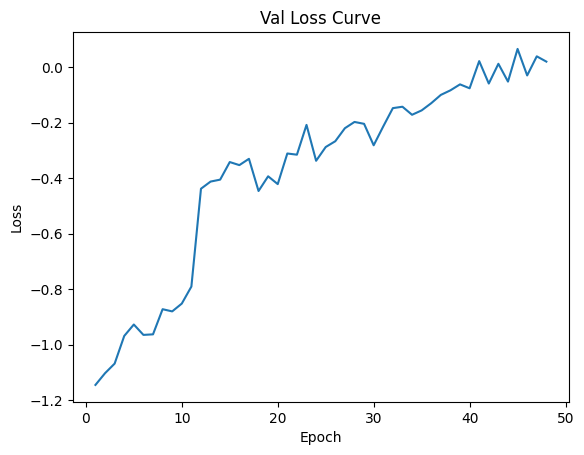

Student weights and architecture saved and exported for lambda: 5


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.4205846225514132


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.8952175974845886


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.6238865486400968


100%|█████████████████████████████████████████| 136/136 [01:41<00:00,  1.34it/s]


Average Pretrain Adversary epoch loss:  0.4971923856612514


100%|█████████████████████████████████████████| 136/136 [01:41<00:00,  1.34it/s]


Average Pretrain Adversary epoch loss:  0.49723031832014813


100%|█████████████████████████████████████████| 136/136 [01:41<00:00,  1.34it/s]


Average Pretrain Adversary epoch loss:  0.497147644048228


100%|█████████████████████████████████████████| 136/136 [01:00<00:00,  2.24it/s]


Average Adversary epoch loss: 0.39008432670551185


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 1/100*****
*****Train Loss: -0.515609 Val Loss: -0.187136*****
*****Validation Accuracy: 62.45%*****
*****Total Avg Disparity: 0.13531265357898864*****

Class Team_Sports: Recall Difference = 0.06673673147661596
Class Celebration: Recall Difference = -0.006976744186046546
Class Parade: Recall Difference = 0.11670185315505499
Class Waiter_Or_Waitress: Recall Difference = -0.18723404255319143
Class Individual_Sports: Recall Difference = -0.10029321103676403
Class Surgeons: Recall Difference = 0.1296703296703297
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.10464559386973193
Class Business: Recall Difference = -0.013853367433930064
Class Dresses: Recall Difference = -0.5023809523809524
Class Water Activities: Recall Difference = 0.13100674059578177
Class Picnic: Recall Difference = -0.16666666666666663
Class Rescue: Recall Difference = 0.05919329491880565
Class Cheering: Recall Difference = -0.006342062193126052
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.30131985553923774


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 2/100*****
*****Train Loss: -0.606557 Val Loss: -0.052893*****
*****Validation Accuracy: 62.28%*****
*****Total Avg Disparity: 0.14554567653686612*****

Class Team_Sports: Recall Difference = 0.02981257663338599
Class Celebration: Recall Difference = 0.06744186046511635
Class Parade: Recall Difference = 0.08972554539056998
Class Waiter_Or_Waitress: Recall Difference = -0.20070921985815593
Class Individual_Sports: Recall Difference = -0.14634238027216007
Class Surgeons: Recall Difference = -0.030036630036630152
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.17385057471264376
Class Business: Recall Difference = 0.12084398976982097
Class Dresses: Recall Difference = -0.5142857142857145
Class Water Activities: Recall Difference = 0.14687975646879736
Class Picnic: Recall Difference = -0.16666666666666669
Class Rescue: Recall Difference = 0.12702985856469357
Class Cheering: Recall Difference = 0.12520458265139123
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.2880462931797785


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 3/100*****
*****Train Loss: -0.657043 Val Loss: -0.078501*****
*****Validation Accuracy: 63.61%*****
*****Total Avg Disparity: 0.1376496084073368*****

Class Team_Sports: Recall Difference = 0.08003736789863958
Class Celebration: Recall Difference = 0.02790697674418602
Class Parade: Recall Difference = 0.0935960591133006
Class Waiter_Or_Waitress: Recall Difference = -0.22340425531914887
Class Individual_Sports: Recall Difference = -0.12856176227351335
Class Surgeons: Recall Difference = -0.04981684981684986
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.11518199233716464
Class Business: Recall Difference = -0.01705029838022165
Class Dresses: Recall Difference = -0.7083333333333334
Class Water Activities: Recall Difference = 0.12241791693846493
Class Picnic: Recall Difference = -0.3333333333333333
Class Rescue: Recall Difference = 0.028025144054478812
Class Cheering: Recall Difference = -0.02823240589198034
Class Performance_A

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.2742480104241301


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 4/100*****
*****Train Loss: -0.630825 Val Loss: -0.029447*****
*****Validation Accuracy: 64.16%*****
*****Total Avg Disparity: 0.13594228924430576*****

Class Team_Sports: Recall Difference = 0.047936007473579734
Class Celebration: Recall Difference = -0.018604651162790642
Class Parade: Recall Difference = 0.078935022284776
Class Waiter_Or_Waitress: Recall Difference = -0.3099290780141841
Class Individual_Sports: Recall Difference = -0.06837831741974298
Class Surgeons: Recall Difference = -0.06153846153846154
Class Spa: Recall Difference = -0.014184397163120477
Class Law_Enforcement: Recall Difference = 0.19109195402298862
Class Business: Recall Difference = -0.0031969309462915874
Class Dresses: Recall Difference = -0.7202380952380952
Class Water Activities: Recall Difference = 0.1822135246792782
Class Picnic: Recall Difference = -0.2037037037037036
Class Rescue: Recall Difference = 0.0568360398114196
Class Cheering: Recall Difference = 0.018821603927986874
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.264312727486386


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 5/100*****
*****Train Loss: -0.625697 Val Loss:  0.065213*****
*****Validation Accuracy: 64.59%*****
*****Total Avg Disparity: 0.1658584538398476*****

Class Team_Sports: Recall Difference = 0.024534360950545953
Class Celebration: Recall Difference = 0.006976744186046546
Class Parade: Recall Difference = 0.06931738212526417
Class Waiter_Or_Waitress: Recall Difference = -0.25106382978723396
Class Individual_Sports: Recall Difference = -0.09311329975189864
Class Surgeons: Recall Difference = -0.10989010989010994
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.19468390804597702
Class Business: Recall Difference = -0.006393861892583064
Class Dresses: Recall Difference = -0.7559523809523809
Class Water Activities: Recall Difference = 0.09284627092846265
Class Picnic: Recall Difference = -0.25925925925925936
Class Rescue: Recall Difference = 0.08590885280251437
Class Cheering: Recall Difference = -0.014525368248772486
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.2507279196425396


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 6/100*****
*****Train Loss: -0.638012 Val Loss:  0.023203*****
*****Validation Accuracy: 64.27%*****
*****Total Avg Disparity: 0.14870510104300888*****

Class Team_Sports: Recall Difference = 0.023413323991358648
Class Celebration: Recall Difference = 0.032558139534883845
Class Parade: Recall Difference = 0.08784893267651894
Class Waiter_Or_Waitress: Recall Difference = -0.18439716312056742
Class Individual_Sports: Recall Difference = -0.14987594917675384
Class Surgeons: Recall Difference = -0.03589743589743588
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.1602011494252874
Class Business: Recall Difference = 0.052216538789428835
Class Dresses: Recall Difference = -0.7499999999999999
Class Water Activities: Recall Difference = 0.11806914546640568
Class Picnic: Recall Difference = 0.03703703703703698
Class Rescue: Recall Difference = 0.11236249345206911
Class Cheering: Recall Difference = 0.044599018003273316
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.27it/s]


Average Adversary epoch loss: 0.24809573952327757


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.25it/s]


*****Epoch 7/100*****
*****Train Loss: -0.632369 Val Loss:  0.063695*****
*****Validation Accuracy: 64.96%*****
*****Total Avg Disparity: 0.1393635599256553*****

Class Team_Sports: Recall Difference = -0.030127868278157055
Class Celebration: Recall Difference = 0.041860465116279055
Class Parade: Recall Difference = 0.07764485104386587
Class Waiter_Or_Waitress: Recall Difference = -0.23120567375886514
Class Individual_Sports: Recall Difference = -0.16754379369972205
Class Surgeons: Recall Difference = -0.03003663003663004
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.09099616858237547
Class Business: Recall Difference = 0.0490196078431373
Class Dresses: Recall Difference = -0.5619047619047619
Class Water Activities: Recall Difference = 0.10437051532941943
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.11733892090099524
Class Cheering: Recall Difference = 0.01943535188216039
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.27it/s]


Average Adversary epoch loss: 0.24426698575125022


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 8/100*****
*****Train Loss: -0.636864 Val Loss:  0.070260*****
*****Validation Accuracy: 64.96%*****
*****Total Avg Disparity: 0.1296164468764034*****

Class Team_Sports: Recall Difference = 0.03401646523033797
Class Celebration: Recall Difference = -0.041860465116279055
Class Parade: Recall Difference = 0.0980530143091719
Class Waiter_Or_Waitress: Recall Difference = -0.28581560283687946
Class Individual_Sports: Recall Difference = -0.16058942936621312
Class Surgeons: Recall Difference = -0.08424908424908423
Class Spa: Recall Difference = 0.07092198581560272
Class Law_Enforcement: Recall Difference = 0.18438697318007657
Class Business: Recall Difference = 0.059036658141517484
Class Dresses: Recall Difference = -0.5142857142857142
Class Water Activities: Recall Difference = 0.1519895629484671
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.11733892090099529
Class Cheering: Recall Difference = -0.06873977086743038
Class Performance_A

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.23580864893601222


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 9/100*****
*****Train Loss: -0.635564 Val Loss:  0.055097*****
*****Validation Accuracy: 64.36%*****
*****Total Avg Disparity: 0.12170703335421268*****

Class Team_Sports: Recall Difference = 0.04305482571378527
Class Celebration: Recall Difference = -0.03488372093023262
Class Parade: Recall Difference = 0.03870513722730462
Class Waiter_Or_Waitress: Recall Difference = -0.25106382978723396
Class Individual_Sports: Recall Difference = -0.0860837531012707
Class Surgeons: Recall Difference = -0.05274725274725278
Class Spa: Recall Difference = 0.028368794326241065
Class Law_Enforcement: Recall Difference = 0.13984674329501923
Class Business: Recall Difference = 0.06223358908780907
Class Dresses: Recall Difference = -0.55
Class Water Activities: Recall Difference = 0.08273537725592517
Class Picnic: Recall Difference = -0.29629629629629634
Class Rescue: Recall Difference = 0.13174436877946571
Class Cheering: Recall Difference = 0.042144026186579364
Class Performance_And_Entertainm

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.27it/s]


Average Adversary epoch loss: 0.24190119960728815


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 10/100*****
*****Train Loss: -0.651196 Val Loss:  0.069213*****
*****Validation Accuracy: 65.17%*****
*****Total Avg Disparity: 0.10957094303129211*****

Class Team_Sports: Recall Difference = 0.0698779704560053
Class Celebration: Recall Difference = -0.03023255813953496
Class Parade: Recall Difference = 0.06169364297443103
Class Waiter_Or_Waitress: Recall Difference = -0.15106382978723387
Class Individual_Sports: Recall Difference = -0.07901661529208326
Class Surgeons: Recall Difference = -0.03003663003663004
Class Spa: Recall Difference = 0.028368794326241065
Class Law_Enforcement: Recall Difference = 0.13936781609195414
Class Business: Recall Difference = 0.029624893435635125
Class Dresses: Recall Difference = -0.55
Class Water Activities: Recall Difference = 0.10795825179386842
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.11707700366684132
Class Cheering: Recall Difference = 0.05585106382978722
Class Performance_And_Entertain

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.2381189697805573


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 11/100*****
*****Train Loss: -0.630115 Val Loss:  0.119239*****
*****Validation Accuracy: 64.01%*****
*****Total Avg Disparity: 0.14670477623530415*****

Class Team_Sports: Recall Difference = 0.07627722309803242
Class Celebration: Recall Difference = 0.01860465116279053
Class Parade: Recall Difference = 0.060989913206661917
Class Waiter_Or_Waitress: Recall Difference = -0.2631205673758864
Class Individual_Sports: Recall Difference = -0.07894143297496425
Class Surgeons: Recall Difference = -0.04981684981684986
Class Spa: Recall Difference = -0.2836879432624115
Class Law_Enforcement: Recall Difference = 0.14966475095785436
Class Business: Recall Difference = 0.004475703324808178
Class Dresses: Recall Difference = -0.7559523809523809
Class Water Activities: Recall Difference = 0.0884974994564035
Class Picnic: Recall Difference = -0.07407407407407418
Class Rescue: Recall Difference = 0.1293871136720796
Class Cheering: Recall Difference = -0.04193944353518825
Class Performance_A

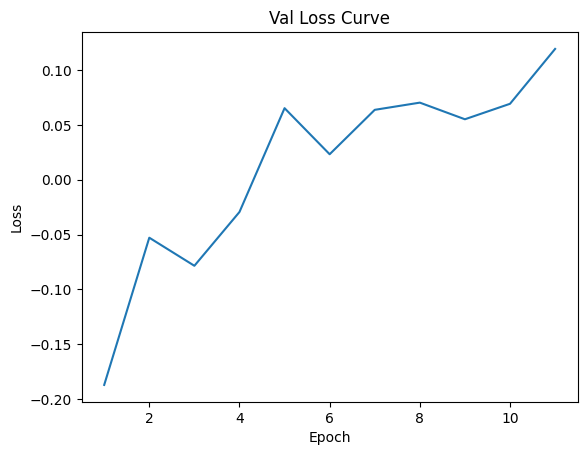

Student weights and architecture saved and exported for lambda: 3


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.4127510575687183


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.8827552431646515


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.5982856042683125


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.5464771911501884


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.5464412574382389


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.5465257932596347


100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.5051560684600297


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 1/100*****
*****Train Loss: -4.374530 Val Loss: -3.976088*****
*****Validation Accuracy: 63.29%*****
*****Total Avg Disparity: 0.12285602243462178*****

Class Team_Sports: Recall Difference = -0.004087113913703533
Class Celebration: Recall Difference = 0.025581395348837188
Class Parade: Recall Difference = 0.17018531550551252
Class Waiter_Or_Waitress: Recall Difference = -0.09787234042553183
Class Individual_Sports: Recall Difference = -0.20660100744304954
Class Surgeons: Recall Difference = -0.01831501831501836
Class Spa: Recall Difference = 0.007092198581560183
Class Law_Enforcement: Recall Difference = 0.1326628352490421
Class Business: Recall Difference = 0.021739130434782594
Class Dresses: Recall Difference = -0.6785714285714285
Class Water Activities: Recall Difference = 0.13318112633181112
Class Picnic: Recall Difference = -0.07407407407407418
Class Rescue: Recall Difference = 0.16788894709271873
Class Cheering: Recall Difference = -0.014116202945990197
Class Performa

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.42711903812254176


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 2/100*****
*****Train Loss: -3.300714 Val Loss: -2.767533*****
*****Validation Accuracy: 61.24%*****
*****Total Avg Disparity: 0.13281771668380477*****

Class Team_Sports: Recall Difference = -0.00581537922578379
Class Celebration: Recall Difference = -0.05348837209302332
Class Parade: Recall Difference = 0.029673938540933698
Class Waiter_Or_Waitress: Recall Difference = -0.14468085106382966
Class Individual_Sports: Recall Difference = -0.16378467784377126
Class Surgeons: Recall Difference = -0.1384615384615384
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.12859195402298862
Class Business: Recall Difference = 0.01534526854219953
Class Dresses: Recall Difference = -0.6488095238095238
Class Water Activities: Recall Difference = 0.12818003913894327
Class Picnic: Recall Difference = 0.03703703703703698
Class Rescue: Recall Difference = 0.04007333682556313
Class Cheering: Recall Difference = -0.038461538461538436
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.3557103248860906


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 3/100*****
*****Train Loss: -3.278153 Val Loss: -2.581396*****
*****Validation Accuracy: 63.35%*****
*****Total Avg Disparity: 0.14716004564032115*****

Class Team_Sports: Recall Difference = 0.04877678519297024
Class Celebration: Recall Difference = 0.041860465116279055
Class Parade: Recall Difference = 0.09875674407694124
Class Waiter_Or_Waitress: Recall Difference = -0.1737588652482268
Class Individual_Sports: Recall Difference = -0.16047665589053473
Class Surgeons: Recall Difference = 0.08131868131868125
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.14607279693486597
Class Business: Recall Difference = 0.007459505541347
Class Dresses: Recall Difference = -0.7023809523809523
Class Water Activities: Recall Difference = 0.1548162644053055
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.1558407543216343
Class Cheering: Recall Difference = -0.0443944353518822
Class Performance_And_En

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.3417160009198329


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 4/100*****
*****Train Loss: -3.215768 Val Loss: -2.581180*****
*****Validation Accuracy: 62.97%*****
*****Total Avg Disparity: 0.13744370529912117*****

Class Team_Sports: Recall Difference = 0.04911543177439115
Class Celebration: Recall Difference = 0.04883720930232549
Class Parade: Recall Difference = 0.11013370865587613
Class Waiter_Or_Waitress: Recall Difference = -0.20992907801418437
Class Individual_Sports: Recall Difference = -0.09683482444928959
Class Surgeons: Recall Difference = 0.07838827838827828
Class Spa: Recall Difference = -0.22695035460992918
Class Law_Enforcement: Recall Difference = 0.10081417624521061
Class Business: Recall Difference = 0.013000852514919004
Class Dresses: Recall Difference = -0.630952380952381
Class Water Activities: Recall Difference = 0.1065449010654489
Class Picnic: Recall Difference = 0.07407407407407396
Class Rescue: Recall Difference = 0.1341016238868517
Class Cheering: Recall Difference = 0.10085924713584293
Class Performance_And_E

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.3329790673930855


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 5/100*****
*****Train Loss: -3.232346 Val Loss: -2.557798*****
*****Validation Accuracy: 64.01%*****
*****Total Avg Disparity: 0.16284449974035942*****

Class Team_Sports: Recall Difference = 0.06729724995620956
Class Celebration: Recall Difference = -0.04186046511627911
Class Parade: Recall Difference = 0.09547267182735164
Class Waiter_Or_Waitress: Recall Difference = -0.22340425531914887
Class Individual_Sports: Recall Difference = -0.1145402601308173
Class Surgeons: Recall Difference = 0.13553113553113555
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.10799808429118762
Class Business: Recall Difference = 0.10784313725490191
Class Dresses: Recall Difference = -0.7202380952380952
Class Water Activities: Recall Difference = 0.10437051532941943
Class Picnic: Recall Difference = 0.03703703703703698
Class Rescue: Recall Difference = 0.1702462022001049
Class Cheering: Recall Difference = -0.030278232405892003
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.33355450871236186


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 6/100*****
*****Train Loss: -3.217531 Val Loss: -2.481637*****
*****Validation Accuracy: 63.92%*****
*****Total Avg Disparity: 0.16020019006979122*****

Class Team_Sports: Recall Difference = 0.0646581421147896
Class Celebration: Recall Difference = 0.07209302325581396
Class Parade: Recall Difference = 0.0828055360075064
Class Waiter_Or_Waitress: Recall Difference = -0.24468085106382964
Class Individual_Sports: Recall Difference = -0.0755582287046086
Class Surgeons: Recall Difference = 0.05567765567765559
Class Spa: Recall Difference = -0.30496453900709214
Class Law_Enforcement: Recall Difference = 0.16666666666666674
Class Business: Recall Difference = 0.09271099744245515
Class Dresses: Recall Difference = -0.6547619047619048
Class Water Activities: Recall Difference = 0.1339421613394216
Class Picnic: Recall Difference = 0.12962962962962954
Class Rescue: Recall Difference = 0.12441068622315349
Class Cheering: Recall Difference = -0.09103927986906718
Class Performance_And_En

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.32959231942453804


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 7/100*****
*****Train Loss: -3.171484 Val Loss: -2.521671*****
*****Validation Accuracy: 64.76%*****
*****Total Avg Disparity: 0.1608276582325152*****

Class Team_Sports: Recall Difference = 0.06387575173702353
Class Celebration: Recall Difference = -0.009302325581395321
Class Parade: Recall Difference = 0.07377433732113536
Class Waiter_Or_Waitress: Recall Difference = -0.22836879432624102
Class Individual_Sports: Recall Difference = -0.10724757537027296
Class Surgeons: Recall Difference = 0.03003663003662993
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.12212643678160928
Class Business: Recall Difference = 0.0980392156862746
Class Dresses: Recall Difference = -0.738095238095238
Class Water Activities: Recall Difference = 0.08273537725592517
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.10267155578837084
Class Cheering: Recall Difference = -0.09513093289689034
Class Performance_And

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.3239301726879442


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 8/100*****
*****Train Loss: -3.167103 Val Loss: -2.376027*****
*****Validation Accuracy: 64.13%*****
*****Total Avg Disparity: 0.15908849466791536*****

Class Team_Sports: Recall Difference = 0.02947393005196486
Class Celebration: Recall Difference = -0.04418604651162794
Class Parade: Recall Difference = 0.12678864649307997
Class Waiter_Or_Waitress: Recall Difference = -0.24184397163120563
Class Individual_Sports: Recall Difference = -0.18521163822269004
Class Surgeons: Recall Difference = 0.05274725274725289
Class Spa: Recall Difference = -0.2836879432624115
Class Law_Enforcement: Recall Difference = 0.1704980842911875
Class Business: Recall Difference = 0.037084398976982125
Class Dresses: Recall Difference = -0.6369047619047619
Class Water Activities: Recall Difference = 0.11230702326592745
Class Picnic: Recall Difference = -0.24074074074074087
Class Rescue: Recall Difference = 0.11943425877422736
Class Cheering: Recall Difference = -0.07937806873977082
Class Performance_A

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.3160968562040259


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 9/100*****
*****Train Loss: -3.095645 Val Loss: -2.345923*****
*****Validation Accuracy: 65.22%*****
*****Total Avg Disparity: 0.165937716018228*****

Class Team_Sports: Recall Difference = 0.05287557657499853
Class Celebration: Recall Difference = -0.03255813953488362
Class Parade: Recall Difference = 0.13699272812573315
Class Waiter_Or_Waitress: Recall Difference = -0.1978723404255318
Class Individual_Sports: Recall Difference = -0.1885948424930457
Class Surgeons: Recall Difference = 0.11575091575091573
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.15613026819923376
Class Business: Recall Difference = 0.05136402387041772
Class Dresses: Recall Difference = -0.6964285714285714
Class Water Activities: Recall Difference = 0.12459230267449439
Class Picnic: Recall Difference = 0.01851851851851849
Class Rescue: Recall Difference = 0.12441068622315349
Class Cheering: Recall Difference = -0.038870703764320724
Class Performance_And_

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.3173271274084554


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 10/100*****
*****Train Loss: -3.056576 Val Loss: -2.335325*****
*****Validation Accuracy: 64.88%*****
*****Total Avg Disparity: 0.1634688835287843*****

Class Team_Sports: Recall Difference = 0.053716354294389035
Class Celebration: Recall Difference = 0.016279069767441756
Class Parade: Recall Difference = 0.05782312925170052
Class Waiter_Or_Waitress: Recall Difference = -0.18865248226950337
Class Individual_Sports: Recall Difference = -0.13217051349522602
Class Surgeons: Recall Difference = 0.10695970695970697
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.19468390804597702
Class Business: Recall Difference = -0.05647911338448419
Class Dresses: Recall Difference = -0.6547619047619049
Class Water Activities: Recall Difference = 0.13176777560339192
Class Picnic: Recall Difference = -0.25925925925925936
Class Rescue: Recall Difference = 0.01833420639078054
Class Cheering: Recall Difference = -0.1067921440261867
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.27535638103590293


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 11/100*****
*****Train Loss: -2.364676 Val Loss: -1.632255*****
*****Validation Accuracy: 65.08%*****
*****Total Avg Disparity: 0.12896710068796224*****

Class Team_Sports: Recall Difference = 0.0404157178723652
Class Celebration: Recall Difference = -0.03023255813953496
Class Parade: Recall Difference = 0.0826882477128782
Class Waiter_Or_Waitress: Recall Difference = -0.17517730496453898
Class Individual_Sports: Recall Difference = -0.16032629125629672
Class Surgeons: Recall Difference = 0.013186813186813251
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.10488505747126442
Class Business: Recall Difference = 0.025149190110826947
Class Dresses: Recall Difference = -0.7023809523809523
Class Water Activities: Recall Difference = 0.10002174385736007
Class Picnic: Recall Difference = 0.01851851851851838
Class Rescue: Recall Difference = 0.07621791513881615
Class Cheering: Recall Difference = -0.11129296235679215
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.2413292247802019


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 12/100*****
*****Train Loss: -2.340148 Val Loss: -1.507618*****
*****Validation Accuracy: 65.51%*****
*****Total Avg Disparity: 0.1609102310617473*****

Class Team_Sports: Recall Difference = 0.03699421965317917
Class Celebration: Recall Difference = 0.04418604651162794
Class Parade: Recall Difference = 0.04128547970912522
Class Waiter_Or_Waitress: Recall Difference = -0.2085106382978723
Class Individual_Sports: Recall Difference = -0.15683031351026255
Class Surgeons: Recall Difference = 0.030036630036629985
Class Spa: Recall Difference = -0.47517730496453897
Class Law_Enforcement: Recall Difference = 0.14942528735632177
Class Business: Recall Difference = 0.05669224211423696
Class Dresses: Recall Difference = -0.6904761904761905
Class Water Activities: Recall Difference = 0.13176777560339203
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.17260345730749083
Class Cheering: Recall Difference = -0.02680032733224219
Class Performance_A

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.23445994461722233


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 13/100*****
*****Train Loss: -2.341542 Val Loss: -1.604716*****
*****Validation Accuracy: 63.81%*****
*****Total Avg Disparity: 0.14901595408246276*****

Class Team_Sports: Recall Difference = 0.0005138086062943525
Class Celebration: Recall Difference = 0.016279069767441867
Class Parade: Recall Difference = 0.08655876143560859
Class Waiter_Or_Waitress: Recall Difference = -0.26453900709219835
Class Individual_Sports: Recall Difference = -0.14980076685963473
Class Surgeons: Recall Difference = -0.046886446886446886
Class Spa: Recall Difference = -0.2624113475177306
Class Law_Enforcement: Recall Difference = 0.09075670498084287
Class Business: Recall Difference = 0.03069053708439895
Class Dresses: Recall Difference = -0.6726190476190476
Class Water Activities: Recall Difference = 0.09425962165688173
Class Picnic: Recall Difference = 0.12962962962962965
Class Rescue: Recall Difference = 0.16553169198533263
Class Cheering: Recall Difference = -0.01554828150572829
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.23584276651415756


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 14/100*****
*****Train Loss: -2.286611 Val Loss: -1.594489*****
*****Validation Accuracy: 64.16%*****
*****Total Avg Disparity: 0.15845948427607642*****

Class Team_Sports: Recall Difference = 0.03609505459216433
Class Celebration: Recall Difference = 0.02093023255813964
Class Parade: Recall Difference = 0.05594651653764937
Class Waiter_Or_Waitress: Recall Difference = -0.26453900709219835
Class Individual_Sports: Recall Difference = -0.1710773626043155
Class Surgeons: Recall Difference = 0.1443223443223443
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.13960727969348652
Class Business: Recall Difference = 0.023017902813299296
Class Dresses: Recall Difference = -0.6904761904761905
Class Water Activities: Recall Difference = 0.09425962165688173
Class Picnic: Recall Difference = 0.09259259259259245
Class Rescue: Recall Difference = 0.16815086432687273
Class Cheering: Recall Difference = -0.09308510638297868
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.23285569201278336


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 15/100*****
*****Train Loss: -2.305101 Val Loss: -1.570792*****
*****Validation Accuracy: 64.01%*****
*****Total Avg Disparity: 0.1375394871550193*****

Class Team_Sports: Recall Difference = 0.03609505459216433
Class Celebration: Recall Difference = 0.06511627906976741
Class Parade: Recall Difference = 0.07694112127609665
Class Waiter_Or_Waitress: Recall Difference = -0.12978723404255332
Class Individual_Sports: Recall Difference = -0.1818284339523345
Class Surgeons: Recall Difference = 0.00439560439560438
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.1012931034482758
Class Business: Recall Difference = -0.004262574595055413
Class Dresses: Recall Difference = -0.6785714285714285
Class Water Activities: Recall Difference = 0.10002174385736007
Class Picnic: Recall Difference = -0.05555555555555558
Class Rescue: Recall Difference = 0.15584075432163436
Class Cheering: Recall Difference = -0.0591243862520458
Class Performance_And

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.23280336757135742


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 16/100*****
*****Train Loss: -2.265507 Val Loss: -1.448365*****
*****Validation Accuracy: 64.30%*****
*****Total Avg Disparity: 0.16043195619585765*****

Class Team_Sports: Recall Difference = 0.040976236351958906
Class Celebration: Recall Difference = -0.03953488372093028
Class Parade: Recall Difference = 0.06673703964344357
Class Waiter_Or_Waitress: Recall Difference = -0.24184397163120575
Class Individual_Sports: Recall Difference = -0.1710021802871966
Class Surgeons: Recall Difference = -0.07838827838827839
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.13888888888888895
Class Business: Recall Difference = -0.10102301790281343
Class Dresses: Recall Difference = -0.6726190476190476
Class Water Activities: Recall Difference = 0.10078277886497067
Class Picnic: Recall Difference = -0.0185185185185186
Class Rescue: Recall Difference = 0.08564693556836034
Class Cheering: Recall Difference = -0.03130114566284792
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.2305219741538167


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 17/100*****
*****Train Loss: -2.261292 Val Loss: -1.591641*****
*****Validation Accuracy: 64.27%*****
*****Total Avg Disparity: 0.15010163304722265*****

Class Team_Sports: Recall Difference = 0.07397676183803359
Class Celebration: Recall Difference = -0.027906976744185963
Class Parade: Recall Difference = 0.08773164438189074
Class Waiter_Or_Waitress: Recall Difference = -0.24184397163120563
Class Individual_Sports: Recall Difference = -0.15333433576422828
Class Surgeons: Recall Difference = 0.02710622710622712
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.11159003831417624
Class Business: Recall Difference = -0.07502131287297525
Class Dresses: Recall Difference = -0.6964285714285714
Class Water Activities: Recall Difference = 0.10795825179386831
Class Picnic: Recall Difference = -0.05555555555555558
Class Rescue: Recall Difference = 0.11733892090099524
Class Cheering: Recall Difference = -0.029255319148936143
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.22642347370000446


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 18/100*****
*****Train Loss: -2.252832 Val Loss: -1.498120*****
*****Validation Accuracy: 63.98%*****
*****Total Avg Disparity: 0.15884489799290086*****

Class Team_Sports: Recall Difference = 0.02481462019034264
Class Celebration: Recall Difference = 0.05813953488372087
Class Parade: Recall Difference = 0.10309641097818434
Class Waiter_Or_Waitress: Recall Difference = -0.3085106382978723
Class Individual_Sports: Recall Difference = -0.14980076685963462
Class Surgeons: Recall Difference = 0.00439560439560438
Class Spa: Recall Difference = -0.326241134751773
Class Law_Enforcement: Recall Difference = 0.10488505747126442
Class Business: Recall Difference = 0.004475703324808178
Class Dresses: Recall Difference = -0.7916666666666666
Class Water Activities: Recall Difference = 0.14764079147640785
Class Picnic: Recall Difference = 0.05555555555555547
Class Rescue: Recall Difference = 0.10502881089575694
Class Cheering: Recall Difference = -0.037847790507364976
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.22908914056332672


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 19/100*****
*****Train Loss: -2.235417 Val Loss: -1.420910*****
*****Validation Accuracy: 62.71%*****
*****Total Avg Disparity: 0.14186009044462916*****

Class Team_Sports: Recall Difference = 0.0696560985578325
Class Celebration: Recall Difference = -0.06511627906976747
Class Parade: Recall Difference = 0.09992962702322306
Class Waiter_Or_Waitress: Recall Difference = -0.15531914893617005
Class Individual_Sports: Recall Difference = -0.14269603789188778
Class Surgeons: Recall Difference = 0.03003663003663004
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.1290708812260536
Class Business: Recall Difference = -0.007459505541347
Class Dresses: Recall Difference = -0.761904761904762
Class Water Activities: Recall Difference = 0.13176777560339203
Class Picnic: Recall Difference = -0.11111111111111105
Class Rescue: Recall Difference = 0.015715034049240406
Class Cheering: Recall Difference = -0.023117839607201263
Class Performance_A

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.22495869054075548


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 20/100*****
*****Train Loss: -2.229185 Val Loss: -1.575459*****
*****Validation Accuracy: 63.61%*****
*****Total Avg Disparity: 0.12869359942662975*****

Class Team_Sports: Recall Difference = 0.06611782565539803
Class Celebration: Recall Difference = -0.0720930232558139
Class Parade: Recall Difference = 0.18355618109312677
Class Waiter_Or_Waitress: Recall Difference = -0.20992907801418448
Class Individual_Sports: Recall Difference = -0.08258777535523665
Class Surgeons: Recall Difference = 0.01025641025641022
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.08429118773946376
Class Business: Recall Difference = -0.07395566922421143
Class Dresses: Recall Difference = -0.7083333333333333
Class Water Activities: Recall Difference = 0.1361165470754513
Class Picnic: Recall Difference = -0.11111111111111105
Class Rescue: Recall Difference = 0.10764798323729696
Class Cheering: Recall Difference = -0.02618657937806873
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.22586332173908458


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 21/100*****
*****Train Loss: -2.225968 Val Loss: -1.404744*****
*****Validation Accuracy: 63.95%*****
*****Total Avg Disparity: 0.15929447988013645*****

Class Team_Sports: Recall Difference = 0.042155660652770544
Class Celebration: Recall Difference = -0.03023255813953485
Class Parade: Recall Difference = 0.15540699038235983
Class Waiter_Or_Waitress: Recall Difference = -0.19645390070921975
Class Individual_Sports: Recall Difference = -0.14637997143071935
Class Surgeons: Recall Difference = 0.09010989010989012
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.18055555555555558
Class Business: Recall Difference = -0.011935208866155178
Class Dresses: Recall Difference = -0.7380952380952381
Class Water Activities: Recall Difference = 0.13752989780387015
Class Picnic: Recall Difference = -1.1102230246251565e-16
Class Rescue: Recall Difference = 0.11969617600838134
Class Cheering: Recall Difference = -0.07017184942716859
Class Perfo

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.2216710123945685


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 22/100*****
*****Train Loss: -2.204298 Val Loss: -1.547410*****
*****Validation Accuracy: 62.91%*****
*****Total Avg Disparity: 0.13989861542800802*****

Class Team_Sports: Recall Difference = 0.05725462719682395
Class Celebration: Recall Difference = 0.023255813953488358
Class Parade: Recall Difference = 0.018883415435139606
Class Waiter_Or_Waitress: Recall Difference = -0.16595744680851066
Class Individual_Sports: Recall Difference = -0.17821968273062183
Class Surgeons: Recall Difference = 0.0073260073260072445
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.23946360153256702
Class Business: Recall Difference = -0.044543904518329125
Class Dresses: Recall Difference = -0.7499999999999999
Class Water Activities: Recall Difference = 0.13535551206784058
Class Picnic: Recall Difference = -0.16666666666666663
Class Rescue: Recall Difference = 0.054478784704033445
Class Cheering: Recall Difference = -0.049509001636661276
Class Perf

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.22038738024147117


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 23/100*****
*****Train Loss: -2.199148 Val Loss: -1.413644*****
*****Validation Accuracy: 62.37%*****
*****Total Avg Disparity: 0.17126152089700677*****

Class Team_Sports: Recall Difference = 0.04013545863256851
Class Celebration: Recall Difference = 0.046511627906976716
Class Parade: Recall Difference = 0.09160215810462125
Class Waiter_Or_Waitress: Recall Difference = -0.32978723404255306
Class Individual_Sports: Recall Difference = -0.18543718517404695
Class Surgeons: Recall Difference = 0.061538461538461486
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.18055555555555558
Class Business: Recall Difference = -0.009803921568627416
Class Dresses: Recall Difference = -0.7261904761904762
Class Water Activities: Recall Difference = 0.1548162644053056
Class Picnic: Recall Difference = -0.14814814814814825
Class Rescue: Recall Difference = 0.16317443687794658
Class Cheering: Recall Difference = -0.08694762684124385
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.2161927410565755


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 24/100*****
*****Train Loss: -2.181961 Val Loss: -1.450626*****
*****Validation Accuracy: 64.50%*****
*****Total Avg Disparity: 0.13229672027580036*****

Class Team_Sports: Recall Difference = 0.032615169031353974
Class Celebration: Recall Difference = 0.04651162790697683
Class Parade: Recall Difference = 0.08210180623973728
Class Waiter_Or_Waitress: Recall Difference = -0.12836879432624104
Class Individual_Sports: Recall Difference = -0.12153221562288552
Class Surgeons: Recall Difference = -0.01831501831501836
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.19803639846743293
Class Business: Recall Difference = -0.013000852514919004
Class Dresses: Recall Difference = -0.738095238095238
Class Water Activities: Recall Difference = 0.16133942161339432
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.07621791513881615
Class Cheering: Recall Difference = 0.02393617021276595
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.21316235961721225


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 25/100*****
*****Train Loss: -2.132388 Val Loss: -1.442585*****
*****Validation Accuracy: 64.56%*****
*****Total Avg Disparity: 0.1609982714608219*****

Class Team_Sports: Recall Difference = 0.023074677409937627
Class Celebration: Recall Difference = 0.004651162790697716
Class Parade: Recall Difference = 0.09934318555008215
Class Waiter_Or_Waitress: Recall Difference = -0.18581560283687948
Class Individual_Sports: Recall Difference = -0.14269603789188778
Class Surgeons: Recall Difference = -0.07838827838827839
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.1254789272030652
Class Business: Recall Difference = -0.05967604433077578
Class Dresses: Recall Difference = -0.7142857142857143
Class Water Activities: Recall Difference = 0.07697325505544672
Class Picnic: Recall Difference = -0.14814814814814814
Class Rescue: Recall Difference = 0.23310633839706651
Class Cheering: Recall Difference = -0.04234860883797059
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.20804250886773362


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 26/100*****
*****Train Loss: -2.148563 Val Loss: -1.545442*****
*****Validation Accuracy: 65.31%*****
*****Total Avg Disparity: 0.15068281617711682*****

Class Team_Sports: Recall Difference = 0.04243591989256745
Class Celebration: Recall Difference = 0.009302325581395321
Class Parade: Recall Difference = 0.061576354679802936
Class Waiter_Or_Waitress: Recall Difference = -0.23900709219858163
Class Individual_Sports: Recall Difference = -0.14622960679648145
Class Surgeons: Recall Difference = 0.010256410256410164
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.11182950191570884
Class Business: Recall Difference = -0.04006820119352095
Class Dresses: Recall Difference = -0.7678571428571428
Class Water Activities: Recall Difference = 0.13970428353989972
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.11236249345206917
Class Cheering: Recall Difference = -0.002864157119476296
Class Perform

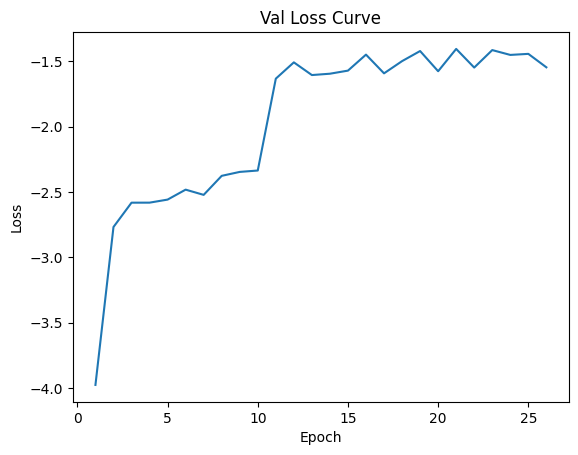

Student weights and architecture saved and exported for lambda: 10


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.4067717965911417


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.8720099720008233


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.5881860847858822


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.39391262303380403


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.3938781213672722


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.3939698432736537


100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.37249971718034325


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 1/100*****
*****Train Loss:  0.214095 Val Loss:  0.593528*****
*****Validation Accuracy: 62.74%*****
*****Total Avg Disparity: 0.13420001609381763*****

Class Team_Sports: Recall Difference = 0.07139604133823796
Class Celebration: Recall Difference = -0.11162790697674424
Class Parade: Recall Difference = 0.15669716162327008
Class Waiter_Or_Waitress: Recall Difference = -0.09787234042553183
Class Individual_Sports: Recall Difference = -0.11093150890910464
Class Surgeons: Recall Difference = 0.03003663003663004
Class Spa: Recall Difference = -0.13475177304964547
Class Law_Enforcement: Recall Difference = 0.14942528735632188
Class Business: Recall Difference = -0.02152600170502983
Class Dresses: Recall Difference = -0.7321428571428571
Class Water Activities: Recall Difference = 0.0358773646444881
Class Picnic: Recall Difference = -0.16666666666666669
Class Rescue: Recall Difference = 0.0785751702462022
Class Cheering: Recall Difference = -0.13113747954173488
Class Performance_A

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.3451473863028428


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 2/100*****
*****Train Loss:  0.096616 Val Loss:  0.629321*****
*****Validation Accuracy: 63.09%*****
*****Total Avg Disparity: 0.10463309319164468*****

Class Team_Sports: Recall Difference = 0.03789338471419412
Class Celebration: Recall Difference = -0.034883720930232565
Class Parade: Recall Difference = 0.12678864649307986
Class Waiter_Or_Waitress: Recall Difference = -0.12340425531914878
Class Individual_Sports: Recall Difference = -0.057664837230283594
Class Surgeons: Recall Difference = 0.0073260073260073
Class Spa: Recall Difference = 0.007092198581560183
Class Law_Enforcement: Recall Difference = 0.07662835249042155
Class Business: Recall Difference = -0.002131287297527651
Class Dresses: Recall Difference = -0.7202380952380952
Class Water Activities: Recall Difference = 0.1325288106110023
Class Picnic: Recall Difference = -0.16666666666666674
Class Rescue: Recall Difference = 0.037192247249868915
Class Cheering: Recall Difference = 0.008797054009819893
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.3206229287692729


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 3/100*****
*****Train Loss:  0.064694 Val Loss:  0.692607*****
*****Validation Accuracy: 63.23%*****
*****Total Avg Disparity: 0.14553664768227076*****

Class Team_Sports: Recall Difference = 0.0927774858410696
Class Celebration: Recall Difference = -0.05348837209302315
Class Parade: Recall Difference = 0.050785831574008955
Class Waiter_Or_Waitress: Recall Difference = -0.28581560283687935
Class Individual_Sports: Recall Difference = -0.043831290880384954
Class Surgeons: Recall Difference = -0.021245421245421225
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.07064176245210729
Class Business: Recall Difference = 0.0002131287297527651
Class Dresses: Recall Difference = -0.5261904761904761
Class Water Activities: Recall Difference = 0.09643400739291152
Class Picnic: Recall Difference = -0.11111111111111105
Class Rescue: Recall Difference = 0.11471974855945516
Class Cheering: Recall Difference = -0.07937806873977082
Class Performa

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.257109181736322


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 4/100*****
*****Train Loss:  0.025813 Val Loss:  0.633791*****
*****Validation Accuracy: 63.84%*****
*****Total Avg Disparity: 0.13748841704894885*****

Class Team_Sports: Recall Difference = 0.08059788637823329
Class Celebration: Recall Difference = -0.05581395348837204
Class Parade: Recall Difference = 0.06990382359840475
Class Waiter_Or_Waitress: Recall Difference = -0.17517730496453887
Class Individual_Sports: Recall Difference = -0.15348470039846618
Class Surgeons: Recall Difference = -0.18974358974358974
Class Spa: Recall Difference = 0.07092198581560283
Class Law_Enforcement: Recall Difference = 0.16068007662835238
Class Business: Recall Difference = 0.06415174765558396
Class Dresses: Recall Difference = -0.6369047619047619
Class Water Activities: Recall Difference = 0.07479886931941726
Class Picnic: Recall Difference = -0.12962962962962954
Class Rescue: Recall Difference = -0.03012048192771083
Class Cheering: Recall Difference = -0.05400981996726678
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.24580426108749473


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 5/100*****
*****Train Loss:  0.007963 Val Loss:  0.703482*****
*****Validation Accuracy: 63.29%*****
*****Total Avg Disparity: 0.1326426966338118*****

Class Team_Sports: Recall Difference = 0.04041571787236509
Class Celebration: Recall Difference = -0.020930232558139528
Class Parade: Recall Difference = 0.10767065446868418
Class Waiter_Or_Waitress: Recall Difference = -0.12056737588652466
Class Individual_Sports: Recall Difference = -0.06499511314938744
Class Surgeons: Recall Difference = -0.05860805860805862
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.12188697318007669
Class Business: Recall Difference = -0.013000852514919004
Class Dresses: Recall Difference = -0.6547619047619047
Class Water Activities: Recall Difference = 0.12307023265927386
Class Picnic: Recall Difference = 0.01851851851851849
Class Rescue: Recall Difference = 0.049502357255107376
Class Cheering: Recall Difference = -0.05360065466448444
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.2506534836309798


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 6/100*****
*****Train Loss: -0.006796 Val Loss:  0.663330*****
*****Validation Accuracy: 63.41%*****
*****Total Avg Disparity: 0.16165223311667037*****

Class Team_Sports: Recall Difference = 0.036433701173585575
Class Celebration: Recall Difference = -0.1418604651162791
Class Parade: Recall Difference = 0.14907342247243727
Class Waiter_Or_Waitress: Recall Difference = -0.19645390070921964
Class Individual_Sports: Recall Difference = -0.050597699421096265
Class Surgeons: Recall Difference = -0.1296703296703296
Class Spa: Recall Difference = 0.24113475177304966
Class Law_Enforcement: Recall Difference = 0.13960727969348674
Class Business: Recall Difference = 0.002344416027280416
Class Dresses: Recall Difference = -0.6845238095238095
Class Water Activities: Recall Difference = 0.09067188519243308
Class Picnic: Recall Difference = -0.24074074074074087
Class Rescue: Recall Difference = 0.1196961760083814
Class Cheering: Recall Difference = -0.0591243862520458
Class Performance_A

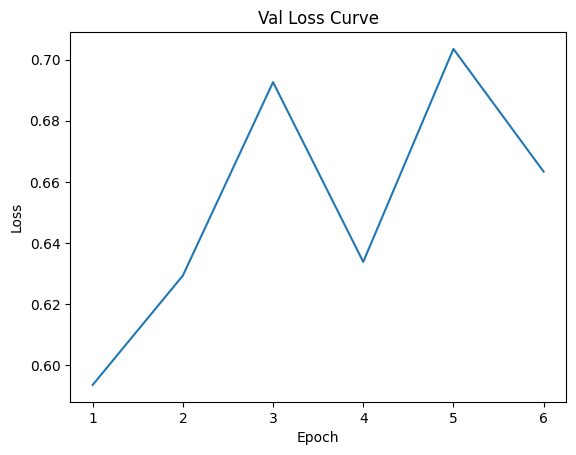

Student weights and architecture saved and exported for lambda: 0.5


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 1/100*****
*****Train Loss:  1.423499 Val Loss:  0.598452*****
*****Validation Accuracy: 58.15%*****
*****Total Avg Disparity: 0.1407900857734708*****

Class Team_Sports: Recall Difference = 0.0460909674782507
Class Celebration: Recall Difference = -0.020930232558139583
Class Parade: Recall Difference = -0.01501290171240921
Class Waiter_Or_Waitress: Recall Difference = -0.2659574468085105
Class Individual_Sports: Recall Difference = -0.13965115404856787
Class Surgeons: Recall Difference = 0.04688644688644683
Class Spa: Recall Difference = 0.21985815602836883
Class Law_Enforcement: Recall Difference = 0.2425766283524904
Class Business: Recall Difference = 0.0837595907928389
Class Dresses: Recall Difference = -0.7142857142857143
Class Water Activities: Recall Difference = 0.09936942813655147
Class Picnic: Recall Difference = -0.03703703703703698
Class Rescue: Recall Difference = 0.013881613410162363
Class Cheering: Recall Difference = 0.0008183306055646322
Class Performance_An

100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 2/100*****
*****Train Loss:  0.886747 Val Loss:  0.575913*****
*****Validation Accuracy: 61.59%*****
*****Total Avg Disparity: 0.14953228376427077*****

Class Team_Sports: Recall Difference = 0.06667834413499174
Class Celebration: Recall Difference = -0.14883720930232558
Class Parade: Recall Difference = 0.035421064977715355
Class Waiter_Or_Waitress: Recall Difference = -0.2737588652482268
Class Individual_Sports: Recall Difference = -0.1535598827155853
Class Surgeons: Recall Difference = -0.024175824175824145
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.1257183908045978
Class Business: Recall Difference = -0.009590792838874651
Class Dresses: Recall Difference = -0.49404761904761907
Class Water Activities: Recall Difference = 0.0813220265275062
Class Picnic: Recall Difference = -0.25925925925925936
Class Rescue: Recall Difference = 0.028025144054478757
Class Cheering: Recall Difference = -0.06260229132569556
Class Performan

100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 3/100*****
*****Train Loss:  0.606221 Val Loss:  0.644269*****
*****Validation Accuracy: 61.88%*****
*****Total Avg Disparity: 0.1499949722461078*****

Class Team_Sports: Recall Difference = 0.07773690663864063
Class Celebration: Recall Difference = -0.051162790697674376
Class Parade: Recall Difference = 0.08913910391742907
Class Waiter_Or_Waitress: Recall Difference = -0.2326241134751772
Class Individual_Sports: Recall Difference = -0.11837455830388699
Class Surgeons: Recall Difference = 0.09890109890109894
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.14607279693486597
Class Business: Recall Difference = -0.019394714407502178
Class Dresses: Recall Difference = -0.7023809523809523
Class Water Activities: Recall Difference = 0.1339421613394216
Class Picnic: Recall Difference = -0.16666666666666663
Class Rescue: Recall Difference = 0.10005238344683076
Class Cheering: Recall Difference = -0.10474631751227487
Class Performance_

100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 4/100*****
*****Train Loss:  0.390032 Val Loss:  0.782556*****
*****Validation Accuracy: 63.61%*****
*****Total Avg Disparity: 0.13779846498223453*****

Class Team_Sports: Recall Difference = 0.07391837449640914
Class Celebration: Recall Difference = 0.016279069767441867
Class Parade: Recall Difference = 0.050199390100867824
Class Waiter_Or_Waitress: Recall Difference = -0.24468085106382975
Class Individual_Sports: Recall Difference = -0.13217051349522602
Class Surgeons: Recall Difference = 0.08131868131868131
Class Spa: Recall Difference = -0.014184397163120477
Class Law_Enforcement: Recall Difference = 0.2224616858237547
Class Business: Recall Difference = -0.02813299232736577
Class Dresses: Recall Difference = -0.7202380952380952
Class Water Activities: Recall Difference = 0.07121113285496827
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.016238868517548466
Class Cheering: Recall Difference = -0.09758592471358424
Class Performan

100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 5/100*****
*****Train Loss:  0.273685 Val Loss:  0.814696*****
*****Validation Accuracy: 63.12%*****
*****Total Avg Disparity: 0.15422309251818117*****

Class Team_Sports: Recall Difference = 0.049454078355812614
Class Celebration: Recall Difference = 0.06976744186046518
Class Parade: Recall Difference = 0.012432559230588835
Class Waiter_Or_Waitress: Recall Difference = -0.25531914893617014
Class Individual_Sports: Recall Difference = -0.1143523043380198
Class Surgeons: Recall Difference = -0.06153846153846154
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.12164750957854409
Class Business: Recall Difference = -0.06820119352088672
Class Dresses: Recall Difference = -0.7202380952380952
Class Water Activities: Recall Difference = 0.09643400739291152
Class Picnic: Recall Difference = -0.20370370370370366
Class Rescue: Recall Difference = 0.1652697747511787
Class Cheering: Recall Difference = -0.11170212765957449
Class Performance_A

100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 6/100*****
*****Train Loss:  0.201990 Val Loss:  0.734215*****
*****Validation Accuracy: 64.21%*****
*****Total Avg Disparity: 0.125552486635926*****

Class Team_Sports: Recall Difference = 0.05461551935540376
Class Celebration: Recall Difference = 0.020930232558139528
Class Parade: Recall Difference = 0.03295801079052296
Class Waiter_Or_Waitress: Recall Difference = -0.2631205673758864
Class Individual_Sports: Recall Difference = -0.16404781595368778
Class Surgeons: Recall Difference = 0.04175824175824183
Class Spa: Recall Difference = -0.014184397163120477
Class Law_Enforcement: Recall Difference = 0.11877394636015326
Class Business: Recall Difference = -0.009590792838874651
Class Dresses: Recall Difference = -0.5559523809523808
Class Water Activities: Recall Difference = 0.11806914546640568
Class Picnic: Recall Difference = -0.07407407407407418
Class Rescue: Recall Difference = 0.0955997904662127
Class Cheering: Recall Difference = -0.06976268412438635
Class Performance_A

100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 7/100*****
*****Train Loss:  0.160086 Val Loss:  0.794136*****
*****Validation Accuracy: 64.04%*****
*****Total Avg Disparity: 0.1421850289092889*****

Class Team_Sports: Recall Difference = 0.026554562970748097
Class Celebration: Recall Difference = 0.0488372093023256
Class Parade: Recall Difference = 0.03553835327234345
Class Waiter_Or_Waitress: Recall Difference = -0.3312056737588651
Class Individual_Sports: Recall Difference = -0.1429591760018044
Class Surgeons: Recall Difference = -0.024175824175824145
Class Spa: Recall Difference = 0.007092198581560294
Class Law_Enforcement: Recall Difference = 0.0737547892720305
Class Business: Recall Difference = -0.026001705029838118
Class Dresses: Recall Difference = -0.7261904761904762
Class Water Activities: Recall Difference = 0.08349641226353555
Class Picnic: Recall Difference = -0.29629629629629634
Class Rescue: Recall Difference = 0.09298061812467256
Class Cheering: Recall Difference = -0.13052373158756142
Class Performance_A

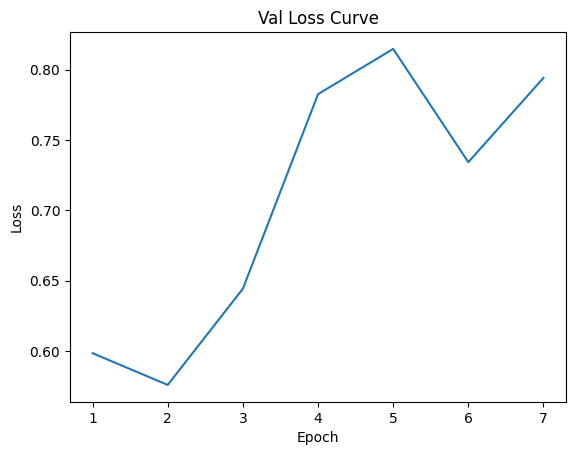

Student weights and architecture saved and exported for lambda: 0


In [23]:
lambda_results = {}
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
    
    if i != 0:
        pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
        pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=i, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    if i in lambda_results:
        # If the key 'i' is already present in the dictionary
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })
    else:
        # If the key 'i' is not present in the dictionary
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }

In [24]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [25]:
# Loop through each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models for the current lambda
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Compute performance metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

    # Compute model sizes and inference times
    teacher_params, student_params = compare_model_size(teacher_model, student_model)
    teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

    # Update results for the current lambda value
    if lmda in lambda_results:
        lambda_results[lmda].update({
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        })
    else:
        lambda_results[lmda] = {
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        }


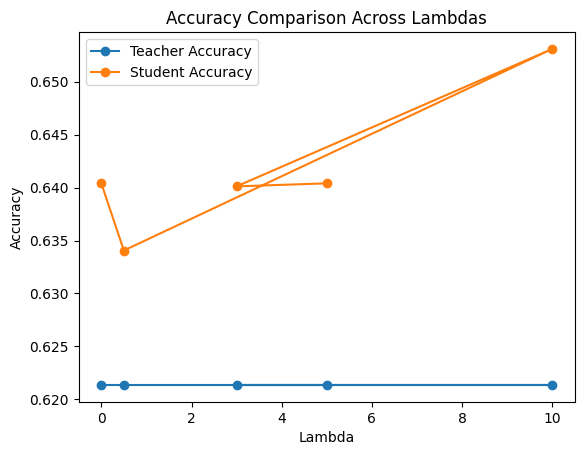

In [26]:
lambdas = list(lambda_results.keys())
teacher_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][0] for lmda in lambdas]
student_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][1] for lmda in lambdas]

plt.plot(lambdas, teacher_accuracies, label='Teacher Accuracy', marker='o')
plt.plot(lambdas, student_accuracies, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


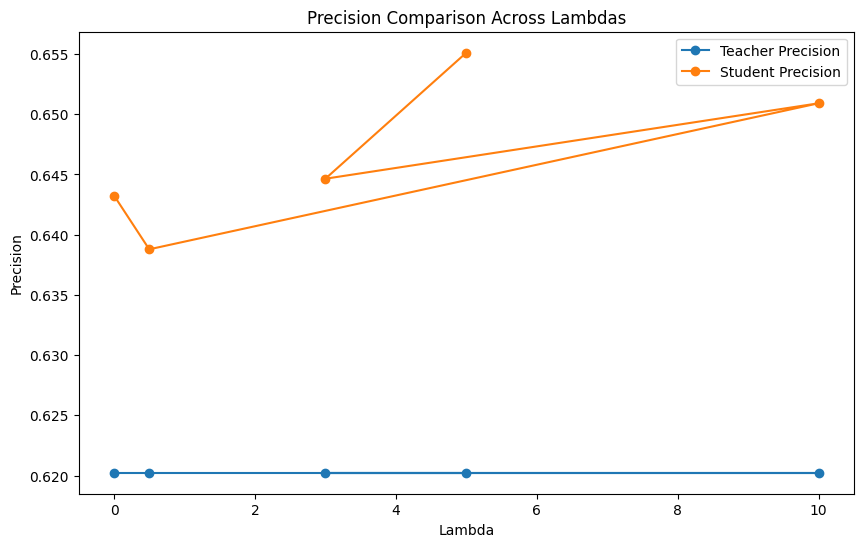

In [27]:
# Precision
teacher_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][0] for lmda in lambdas]
student_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_precisions, label='Teacher Precision', marker='o')
plt.plot(lambdas, student_precisions, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


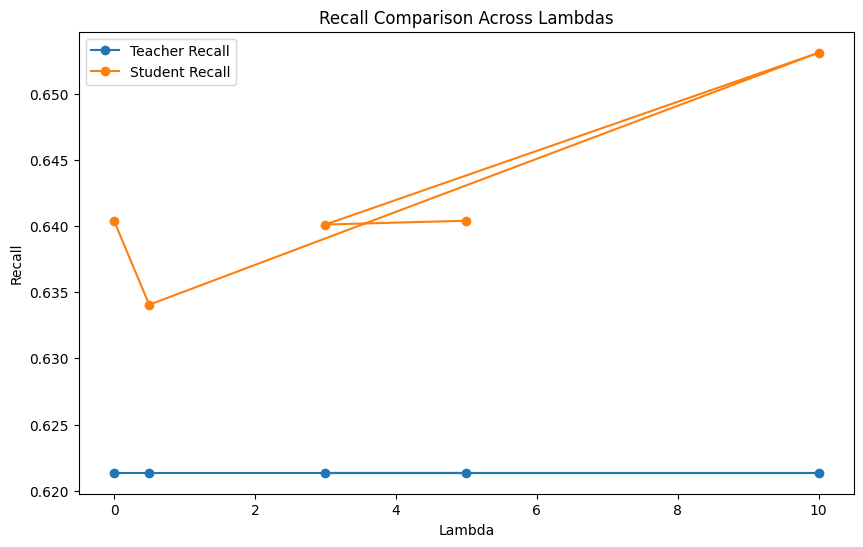

In [28]:
# Recall
teacher_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][0] for lmda in lambdas]
student_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_recalls, label='Teacher Recall', marker='o')
plt.plot(lambdas, student_recalls, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


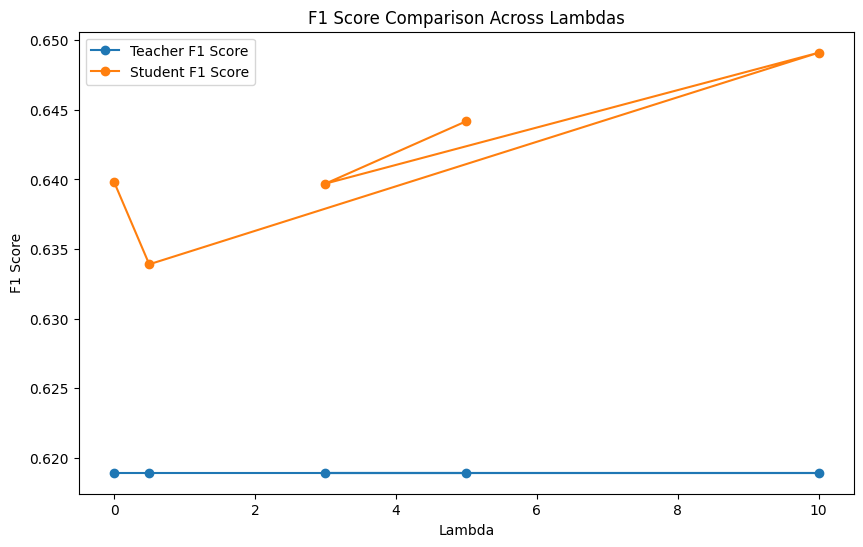

In [29]:
# F1 Score
teacher_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][0] for lmda in lambdas]
student_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_f1s, label='Teacher F1 Score', marker='o')
plt.plot(lambdas, student_f1s, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


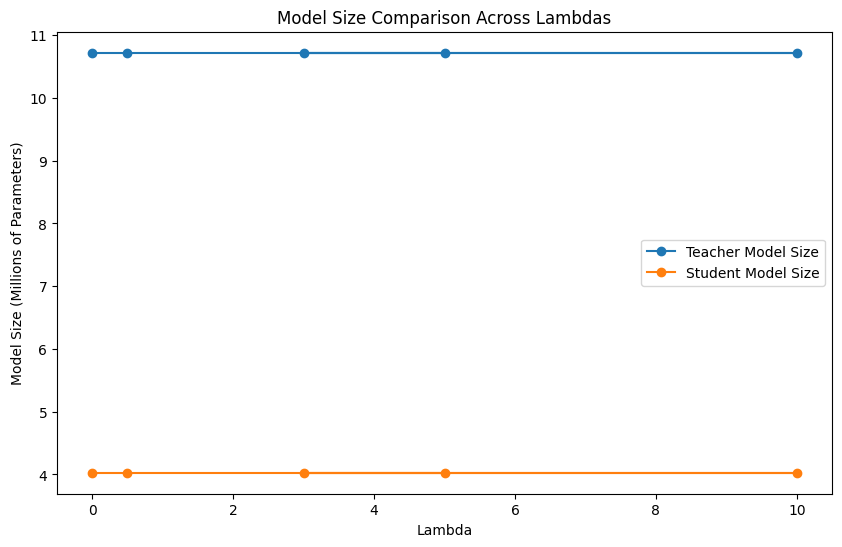

In [30]:
# Model Size
teacher_sizes = [lambda_results[lmda]['teacher_params'] / 1e6 for lmda in lambdas]  # Convert to millions
student_sizes = [lambda_results[lmda]['student_params'] / 1e6 for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_sizes, label='Teacher Model Size', marker='o')
plt.plot(lambdas, student_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


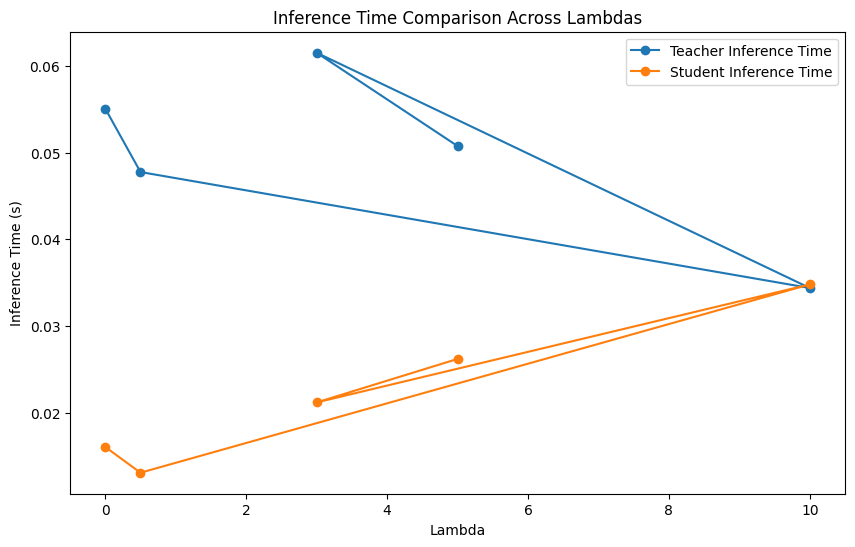

In [31]:
# Inference Time
teacher_times = [lambda_results[lmda]['teacher_time'] for lmda in lambdas]
student_times = [lambda_results[lmda]['student_time'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_times, label='Teacher Inference Time', marker='o')
plt.plot(lambdas, student_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


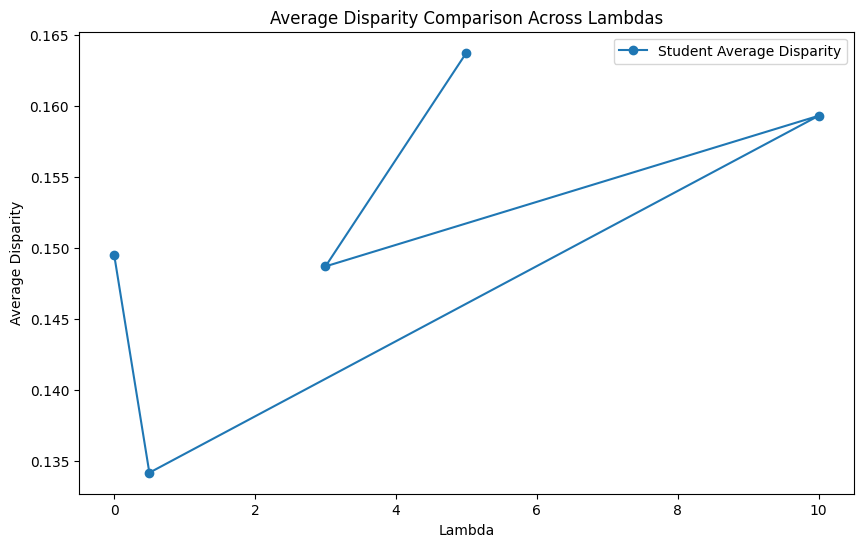

In [32]:
# Extracting disparity values for both teacher and student models
student_disparities = [lambda_results[lmda]['student_mean_abs_val_disparity'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, student_disparities, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [33]:
lambda_results

{5: {'student_mean_abs_val_disparity': 0.16372665552209764,
  'performance_metrics': {'metrics': {'accuracy': (0.6213564213564213,
     0.6404040404040404),
    'precision': (0.620232998383793, 0.6551122411859435),
    'recall': (0.6213564213564213, 0.6404040404040404),
    'f1': (0.6189209821985135, 0.6441833032639486)},
   'all_labels': array([ 2,  2,  2, ..., 13, 13, 13]),
   'all_teacher_preds': array([ 2,  1,  2, ..., 15,  1,  3]),
   'all_student_preds': array([ 2, 13,  1, ..., 15, 11,  8])},
  'teacher_params': 10720824,
  'student_params': 4028044,
  'teacher_time': 0.05077624320983887,
  'student_time': 0.026197195053100586},
 3: {'student_mean_abs_val_disparity': 0.14870510104300888,
  'performance_metrics': {'metrics': {'accuracy': (0.6213564213564213,
     0.6401154401154401),
    'precision': (0.620232998383793, 0.6446472045335933),
    'recall': (0.6213564213564213, 0.6401154401154401),
    'f1': (0.6189209821985135, 0.6396964582689311)},
   'all_labels': array([ 2,  2,  

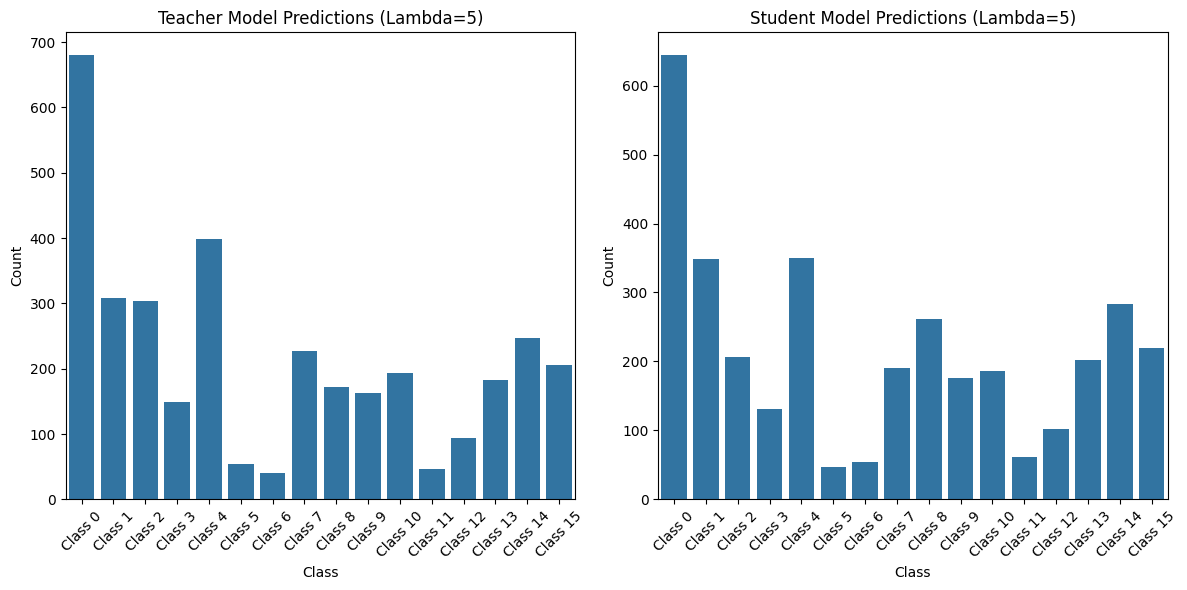

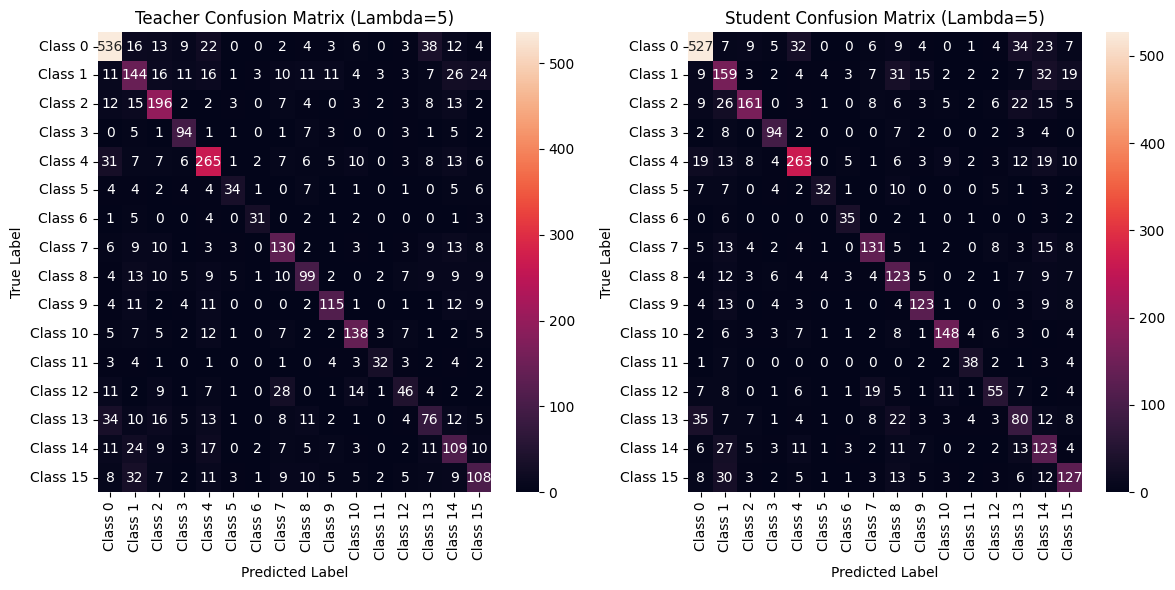

Classification Report - Teacher Model (Lambda=5)
              precision    recall  f1-score   support

     Class 0       0.79      0.80      0.79       668
     Class 1       0.47      0.48      0.47       301
     Class 2       0.64      0.72      0.68       272
     Class 3       0.63      0.76      0.69       124
     Class 4       0.67      0.70      0.68       377
     Class 5       0.63      0.46      0.53        74
     Class 6       0.76      0.62      0.68        50
     Class 7       0.57      0.64      0.61       202
     Class 8       0.58      0.51      0.54       194
     Class 9       0.71      0.66      0.68       173
    Class 10       0.71      0.69      0.70       199
    Class 11       0.70      0.53      0.60        60
    Class 12       0.49      0.36      0.41       129
    Class 13       0.42      0.38      0.40       198
    Class 14       0.44      0.50      0.47       220
    Class 15       0.53      0.48      0.50       224

    accuracy                   

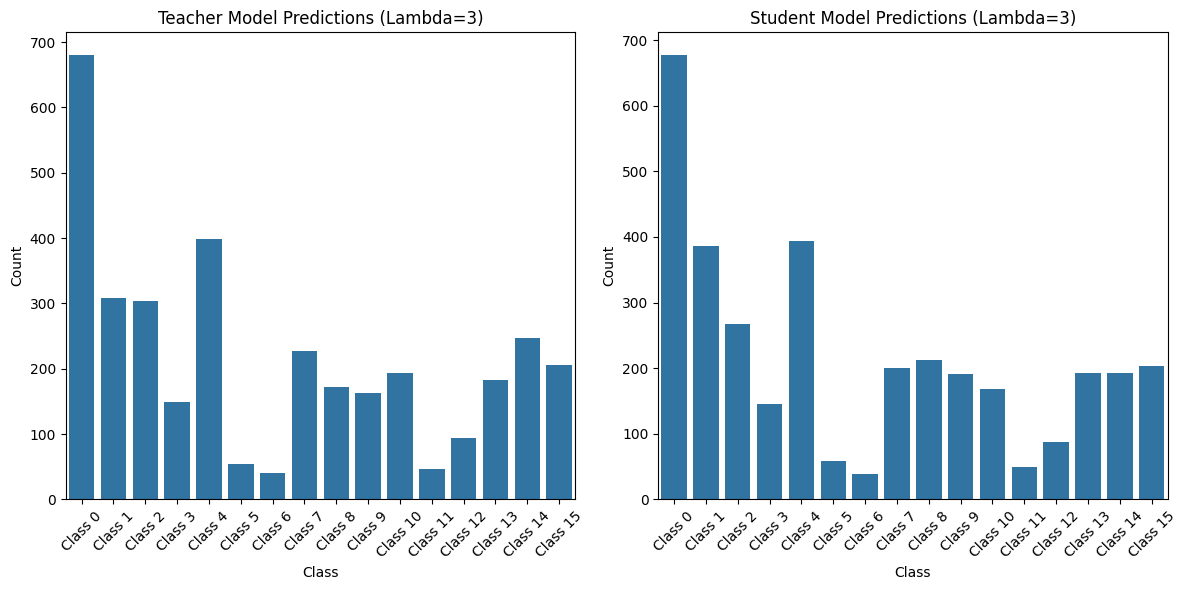

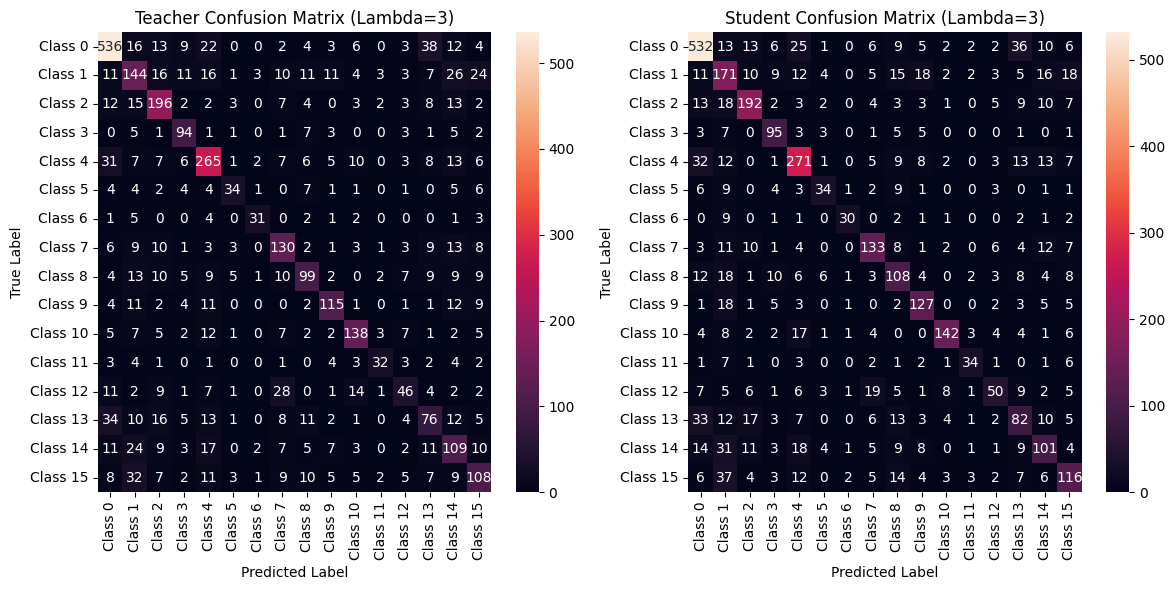

Classification Report - Teacher Model (Lambda=3)
              precision    recall  f1-score   support

     Class 0       0.79      0.80      0.79       668
     Class 1       0.47      0.48      0.47       301
     Class 2       0.64      0.72      0.68       272
     Class 3       0.63      0.76      0.69       124
     Class 4       0.67      0.70      0.68       377
     Class 5       0.63      0.46      0.53        74
     Class 6       0.76      0.62      0.68        50
     Class 7       0.57      0.64      0.61       202
     Class 8       0.58      0.51      0.54       194
     Class 9       0.71      0.66      0.68       173
    Class 10       0.71      0.69      0.70       199
    Class 11       0.70      0.53      0.60        60
    Class 12       0.49      0.36      0.41       129
    Class 13       0.42      0.38      0.40       198
    Class 14       0.44      0.50      0.47       220
    Class 15       0.53      0.48      0.50       224

    accuracy                   

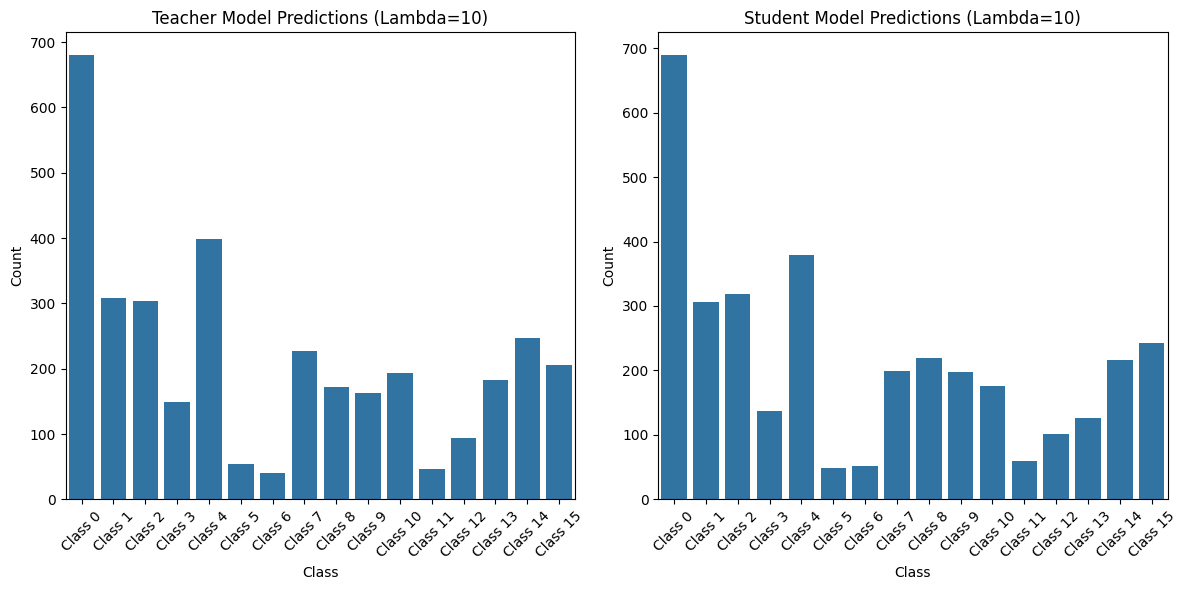

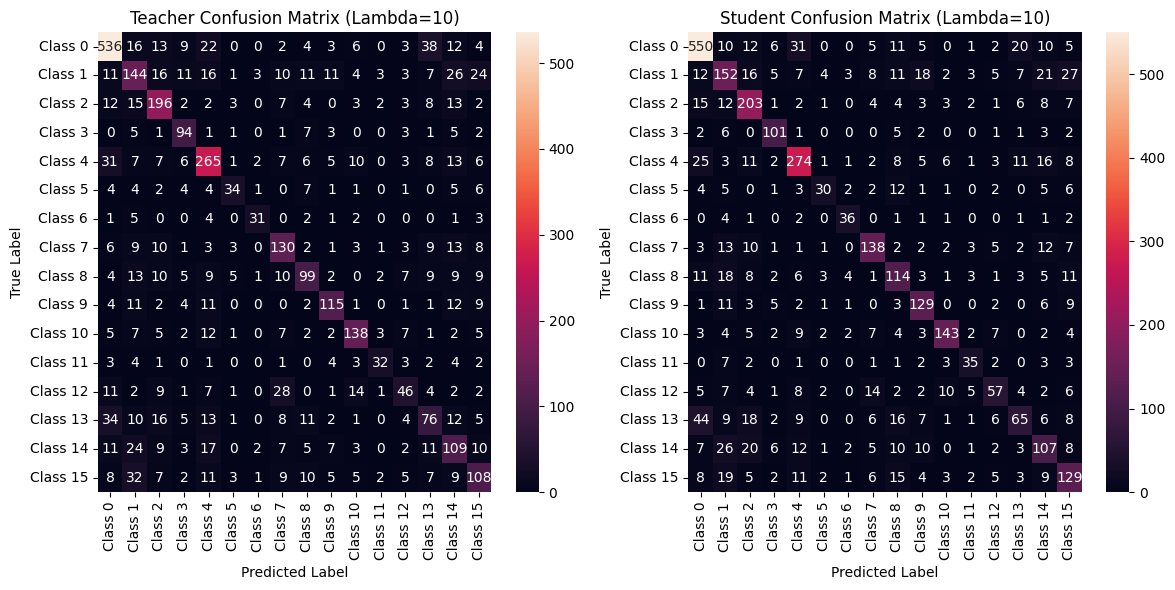

Classification Report - Teacher Model (Lambda=10)
              precision    recall  f1-score   support

     Class 0       0.79      0.80      0.79       668
     Class 1       0.47      0.48      0.47       301
     Class 2       0.64      0.72      0.68       272
     Class 3       0.63      0.76      0.69       124
     Class 4       0.67      0.70      0.68       377
     Class 5       0.63      0.46      0.53        74
     Class 6       0.76      0.62      0.68        50
     Class 7       0.57      0.64      0.61       202
     Class 8       0.58      0.51      0.54       194
     Class 9       0.71      0.66      0.68       173
    Class 10       0.71      0.69      0.70       199
    Class 11       0.70      0.53      0.60        60
    Class 12       0.49      0.36      0.41       129
    Class 13       0.42      0.38      0.40       198
    Class 14       0.44      0.50      0.47       220
    Class 15       0.53      0.48      0.50       224

    accuracy                  

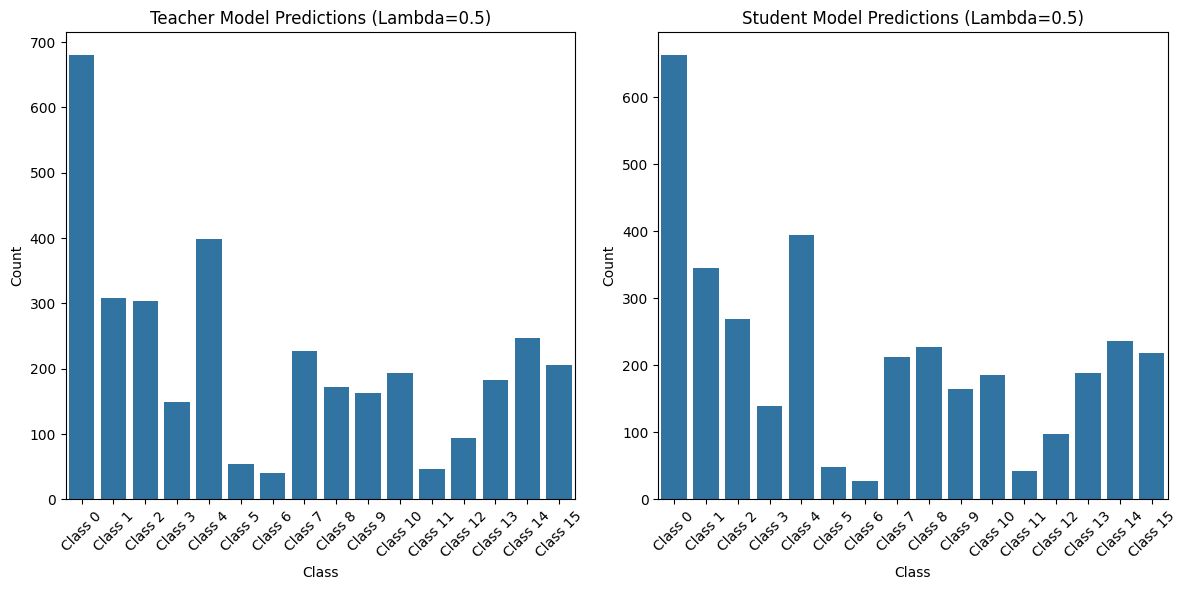

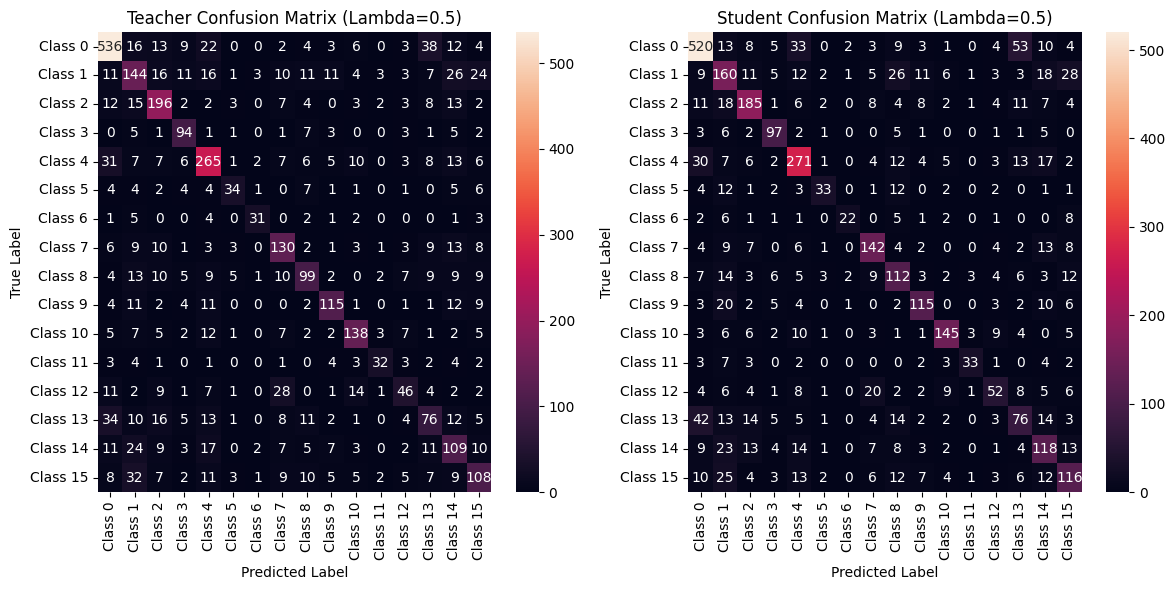

Classification Report - Teacher Model (Lambda=0.5)
              precision    recall  f1-score   support

     Class 0       0.79      0.80      0.79       668
     Class 1       0.47      0.48      0.47       301
     Class 2       0.64      0.72      0.68       272
     Class 3       0.63      0.76      0.69       124
     Class 4       0.67      0.70      0.68       377
     Class 5       0.63      0.46      0.53        74
     Class 6       0.76      0.62      0.68        50
     Class 7       0.57      0.64      0.61       202
     Class 8       0.58      0.51      0.54       194
     Class 9       0.71      0.66      0.68       173
    Class 10       0.71      0.69      0.70       199
    Class 11       0.70      0.53      0.60        60
    Class 12       0.49      0.36      0.41       129
    Class 13       0.42      0.38      0.40       198
    Class 14       0.44      0.50      0.47       220
    Class 15       0.53      0.48      0.50       224

    accuracy                 

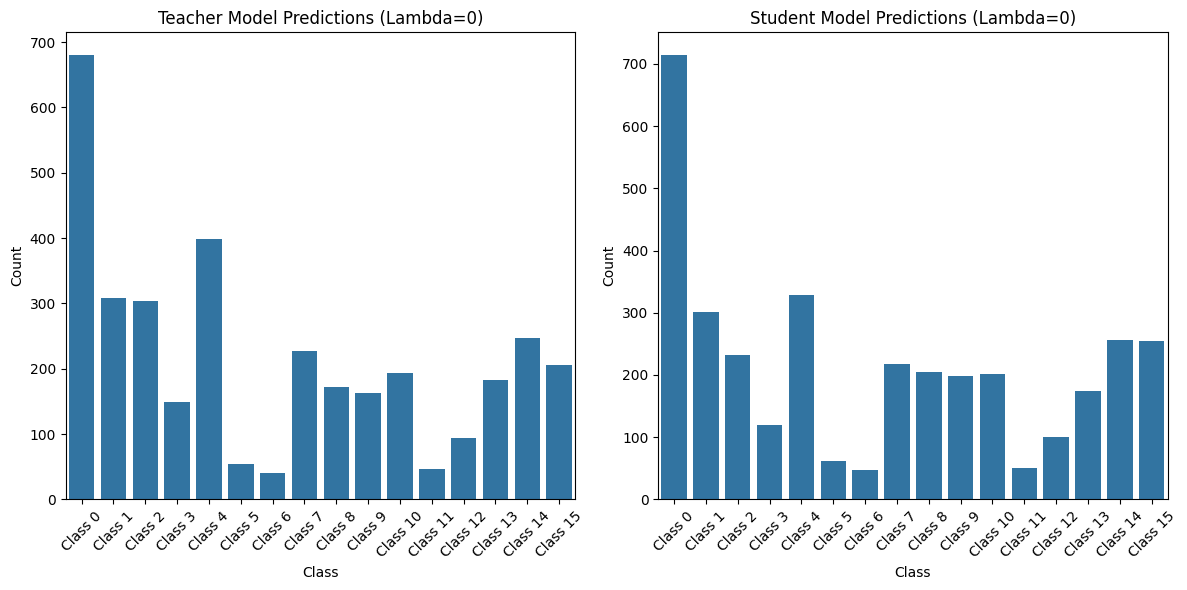

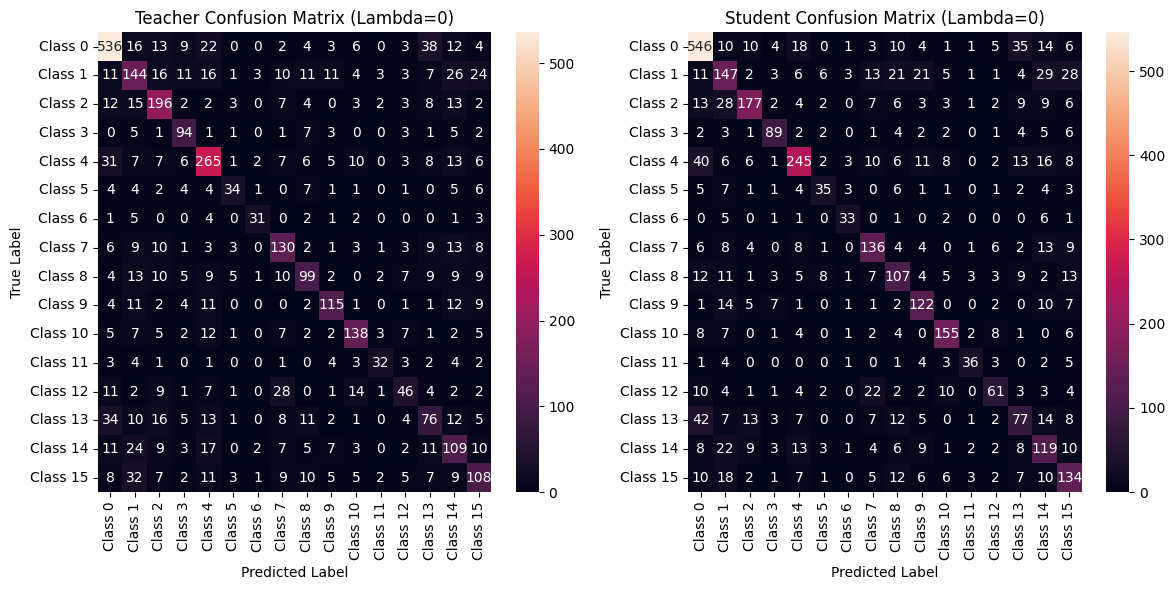

Classification Report - Teacher Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.79      0.80      0.79       668
     Class 1       0.47      0.48      0.47       301
     Class 2       0.64      0.72      0.68       272
     Class 3       0.63      0.76      0.69       124
     Class 4       0.67      0.70      0.68       377
     Class 5       0.63      0.46      0.53        74
     Class 6       0.76      0.62      0.68        50
     Class 7       0.57      0.64      0.61       202
     Class 8       0.58      0.51      0.54       194
     Class 9       0.71      0.66      0.68       173
    Class 10       0.71      0.69      0.70       199
    Class 11       0.70      0.53      0.60        60
    Class 12       0.49      0.36      0.41       129
    Class 13       0.42      0.38      0.40       198
    Class 14       0.44      0.50      0.47       220
    Class 15       0.53      0.48      0.50       224

    accuracy                   

In [34]:
def plot_combined_distribution(teacher_preds, student_preds, class_names, lmda):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=teacher_preds)
    plt.title(f'Teacher Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)

    plt.subplot(1, 2, 2)
    sns.countplot(x=student_preds)
    plt.title(f'Student Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_combined_confusion_matrix(all_labels, teacher_preds, student_preds, class_names, lmda):
    cm_teacher = confusion_matrix(all_labels, teacher_preds)
    cm_student = confusion_matrix(all_labels, student_preds)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(pd.DataFrame(cm_teacher, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Teacher Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    sns.heatmap(pd.DataFrame(cm_student, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Student Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Loop over each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Generate predictions and compute metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    all_labels = performance_metrics['all_labels']
    all_teacher_preds = performance_metrics['all_teacher_preds']
    all_student_preds = performance_metrics['all_student_preds']

    # Plot distribution and confusion matrices
    plot_combined_distribution(all_teacher_preds, all_student_preds, class_names_new, lmda)
    plot_combined_confusion_matrix(all_labels, all_teacher_preds, all_student_preds, class_names_new, lmda)

    # Print classification reports
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda})')
    print(teacher_report)
    print(f'Classification Report - Student Model (Lambda={lmda})')
    print(student_report)


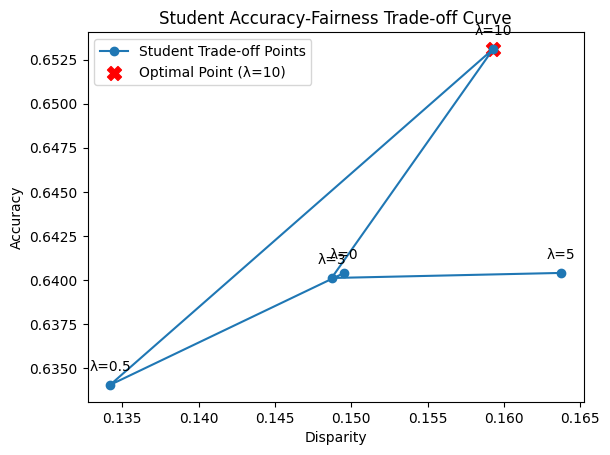

Optimal Lambda for Student: 10
Optimal Bias/Disparity for Student: 0.15929447988013645
Optimal Accuracy for Student: 0.6531024531024531
Optimal Weighted Ratio for Student: 0.56


In [35]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    # Extract bias (disparity) and accuracy values
    if model_type == 'teacher':
        bias_values = [result['teacher_mean_abs_val_disparity'][0] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][0] for result in model_results.values()]
        model_name = "Teacher"
    elif model_type == 'student':
        bias_values = [result['student_mean_abs_val_disparity'] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][1] for result in model_results.values()]
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")

    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")

# Plot for Teacher
# plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)
